**Цель проекта:**

Построить модель для предсказания температуры стали на этапе обработки с целью снижения энергозатрат на металлургическом комбинате «Стальная птица».


**Задача:**

На основе данных о технологическом процессе (подача сыпучих материалов, продувка газом, использование электродов и проволочных материалов) разработать модель, которая будет предсказывать температуру сплава. Модель будет использоваться для имитации процесса и оптимизации потребления электроэнергии.

**Данные:**
- Данные о нагреве дугой, подаче сыпучих и проволочных материалов, продувке газом и замерах температуры.
- Файлы: data_arc_new.csv, data_bulk_new.csv, data_bulk_time_new.csv, data_gas_new.csv, data_temp_new.csv, data_wire_new.csv, data_wire_time_new.csv.

**Основные этапы:**
- Загрузка и первичный анализ данных.
- Исследовательский анализ и предобработка данных.
- Объединение данных в единый датафрейм.
- Подготовка данных для обучения модели.
- Обучение и оценка моделей машинного обучения.
- Выбор лучшей модели и формулирование рекомендаций для заказчика.

# Загрузка библиотек и данных

In [1]:
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


**Загрузка библиотек**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from pathlib import Path
from typing import Dict, Any, List, Optional
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from functools import reduce

RANDOM_STATE, TEST_SIZE = 12345, 0.25

**Загрузка данных**

In [3]:
# Путь к директории с данными
datasets_directory = Path('/datasets/')  # Укажите правильный путь

# Функция для чтения данных с обработкой ошибок
def load_data(file_name, parse_dates=None):
    try:
        data = pd.read_csv(datasets_directory / file_name, parse_dates=parse_dates)
        print(f"Файл {file_name} успешно загружен.")
        return data
    except FileNotFoundError:
        print(f"Ошибка: файл {file_name} не найден.")
        return None
    except Exception as e:
        print(f"Ошибка при загрузке файла {file_name}: {e}")
        return None

# Загрузка данных
arc = load_data('data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
bulk = load_data('data_bulk_new.csv')
bulk_time = load_data('data_bulk_time_new.csv', parse_dates=[f'Bulk {x}' for x in range(1, 16)])
gas = load_data('data_gas_new.csv')
temperature = load_data('data_temp_new.csv', parse_dates=['Время замера'])
wire = load_data('data_wire_new.csv')
wire_time = load_data('data_wire_time_new.csv', parse_dates=[f'Wire {x}' for x in range(1, 10)])

# Проверка загрузки данных
if all(df is not None for df in [arc, bulk, bulk_time, gas, temperature, wire, wire_time]):
    print("Все данные успешно загружены.")
else:
    print("Некоторые данные не загружены.")

Файл data_arc_new.csv успешно загружен.
Файл data_bulk_new.csv успешно загружен.
Файл data_bulk_time_new.csv успешно загружен.
Файл data_gas_new.csv успешно загружен.
Файл data_temp_new.csv успешно загружен.
Файл data_wire_new.csv успешно загружен.
Файл data_wire_time_new.csv успешно загружен.
Все данные успешно загружены.


# Вспомогательные формулы

In [4]:
def transform_columns(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    
    # Приведение названий колонок к нижнему регистру и замена пробелов на _
    df.columns = df.columns.str.replace(' ', '_', regex=True).str.lower()

    # Приведение значений в строковых колонках к нижнему регистру и замена пробелов на _
    object_columns = df.select_dtypes('object').columns
    df = df.assign(**{col: df[col].str.replace(' ', '_', regex=True).str.lower() 
                      for col in object_columns})

    # Сбор информации о данных
    info = {
        'duplicates': df.duplicated().sum(),
        'missing_values': round(df.isna().mean() * 100, 1).sort_values(ascending=False),
        'info': df.info(),
        'describe': df.describe(),
        'head': df.head()
    }

    # Вывод информации, если verbose=True
    if verbose:
        print(f"Явных дублей: {info['duplicates']}\n")
        print("Пропущенных значений (%):")
        display(info['missing_values'])
        print("\nINFO:")
        display(info['info'])
        print("\nDESCRIBE:")
        display(info['describe'])
        print("\nHEAD:")
        display(info['head'])

    return df

In [5]:
def plot_numeric(
    df: pd.DataFrame,
    variables: List[str],
    titles: Optional[List[str]] = None,
    xlabels: Optional[List[str]] = None,
    bins: int = 30,
    figsize: tuple = (20, 7),
    hist_color: str = '#1f77b4',  # Цвет гистограммы
    box_color: str = '#ff7f0e',   # Цвет boxplot
    edge_color: str = 'black',    # Цвет границ гистограммы
    grid_alpha: float = 0.7,      # Прозрачность сетки
    fontsize: int = 14,           # Размер шрифта
) -> None:
 
    # Проверка наличия колонок в DataFrame
    for variable in variables:
        if variable not in df.columns:
            raise ValueError(f"Колонка '{variable}' отсутствует в DataFrame.")

    # Если заголовки или подписи осей не предоставлены, используем названия колонок
    if titles is None:
        titles = variables
    if xlabels is None:
        xlabels = variables

    # Построение графиков для каждой переменной
    for variable, title, xlabel in zip(variables, titles, xlabels):
        # Проверка на пропущенные значения
        if df[variable].isna().any():
            print(f"Внимание: колонка '{variable}' содержит пропущенные значения.")

        # Создание фигуры и осей
        f, (ax1, ax2) = plt.subplots(
            2, 1, figsize=figsize, gridspec_kw={'height_ratios': [4, 1]}
        )
        f.suptitle(title, fontsize=fontsize + 4, fontweight='bold')

        # Гистограмма
        ax1.hist(
            df[variable],
            bins=bins,
            color=hist_color,
            edgecolor=edge_color,
            alpha=0.8
        )
        ax1.set_ylabel('Количество измерений', fontsize=fontsize)
        ax1.tick_params(axis='both', labelsize=fontsize - 2)
        ax1.grid(True, linestyle='--', alpha=grid_alpha)

        # Boxplot
        boxplot = ax2.boxplot(
            df[variable],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor=box_color, color=edge_color),
            whiskerprops=dict(color=edge_color),
            capprops=dict(color=edge_color),
            medianprops=dict(color='red', linewidth=2)
        )
        ax2.set_xlabel(xlabel, fontsize=fontsize)
        ax2.tick_params(axis='both', labelsize=fontsize - 2)
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Добавление аннотации для медианы
        median = df[variable].median()
        ax2.text(
            median,
            1.1,
            f'Медиана: {median:.2f}',
            fontsize=fontsize - 2,
            color='red',
            ha='center'
        )

        # Отображение графиков
        plt.tight_layout()
        plt.show()

# Анализ и обработка данных

**Фрейм data_arc_new.csv**

In [6]:
arc = transform_columns(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
Явных дублей: 0

Пропущенных значений (%):


key                     0.0
начало_нагрева_дугой    0.0
конец_нагрева_дугой     0.0
активная_мощность       0.0
реактивная_мощность     0.0
dtype: float64


INFO:


None


DESCRIBE:


,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



HEAD:


,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


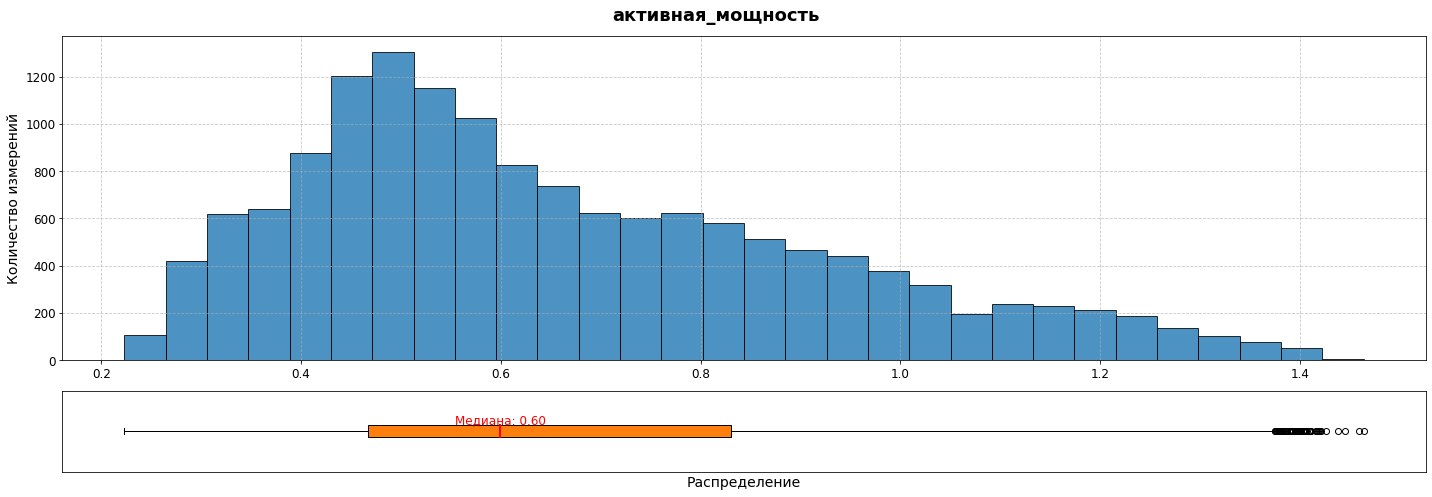

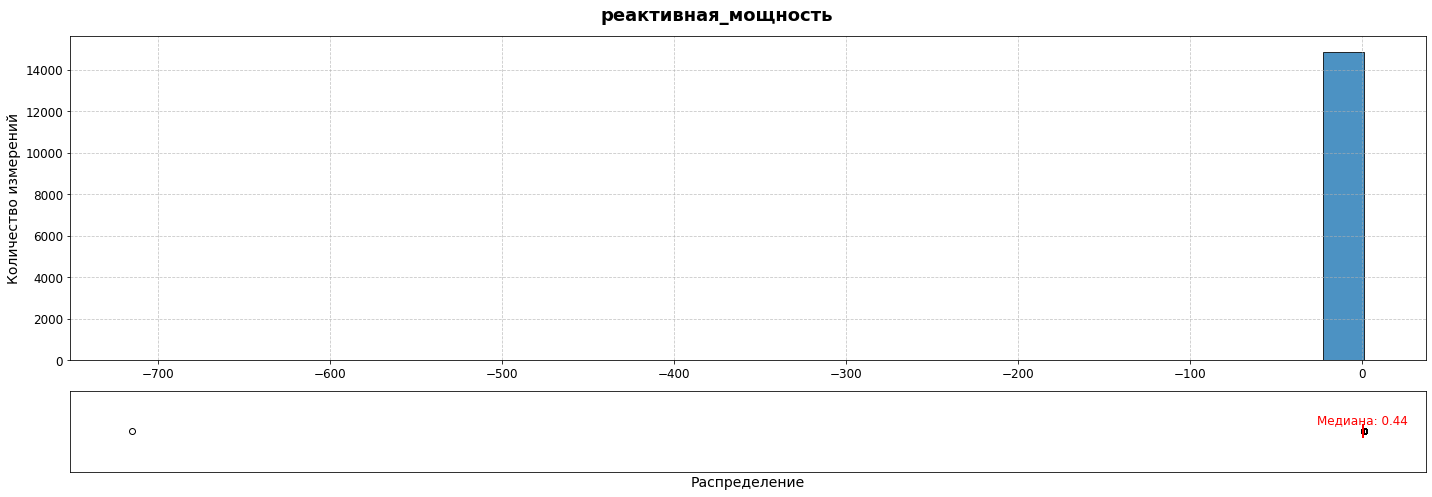

In [7]:
plot_numeric(
    arc,
    variables=['активная_мощность', 'реактивная_мощность'],
    titles=['активная_мощность', 'реактивная_мощность'],
    xlabels=['Распределение', 'Распределение']
)

In [8]:
#Удалим явные выбросы
arc = arc[arc['реактивная_мощность'] > 0]

**Фрейм data_bulk_new.csv**

In [9]:
bulk = transform_columns(bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Явных дублей: 0

Пропущенных значений (%):


bulk_8     100.0
bulk_9      99.4
bulk_13     99.4
bulk_2      99.3
bulk_7      99.2
bulk_5      97.5
bulk_10     94.4
bulk_11     94.3
bulk_1      91.9
bulk_6      81.6
bulk_4      67.6
bulk_3      58.5
bulk_15     28.2
bulk_12     21.7
bulk_14     10.3
key          0.0
dtype: float64


INFO:


None


DESCRIBE:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



HEAD:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Общее количество записей о подаче сыпучих материалов составляет 3129, что меньше общего числа партий. Это означает, что не во все партии добавляются сыпучие материалы. Некоторые материалы используются значительно реже других. Например, материал под номером 8 (Bulk 8) за весь период наблюдений был использован только один раз. Чтобы упростить анализ и обработку данных, заменим пропущенные значения (NaN) в соответствующих столбцах на 0. Это позволит учесть отсутствие добавления материалов в определенные партии.

In [10]:
# Заменяем NaN на 0 в столбцах bulk_1, bulk_2, ..., bulk_15
bulk_columns = [f'bulk_{i}' for i in range(1, 16)]  # Список столбцов
bulk[bulk_columns] = bulk[bulk_columns].fillna(0)

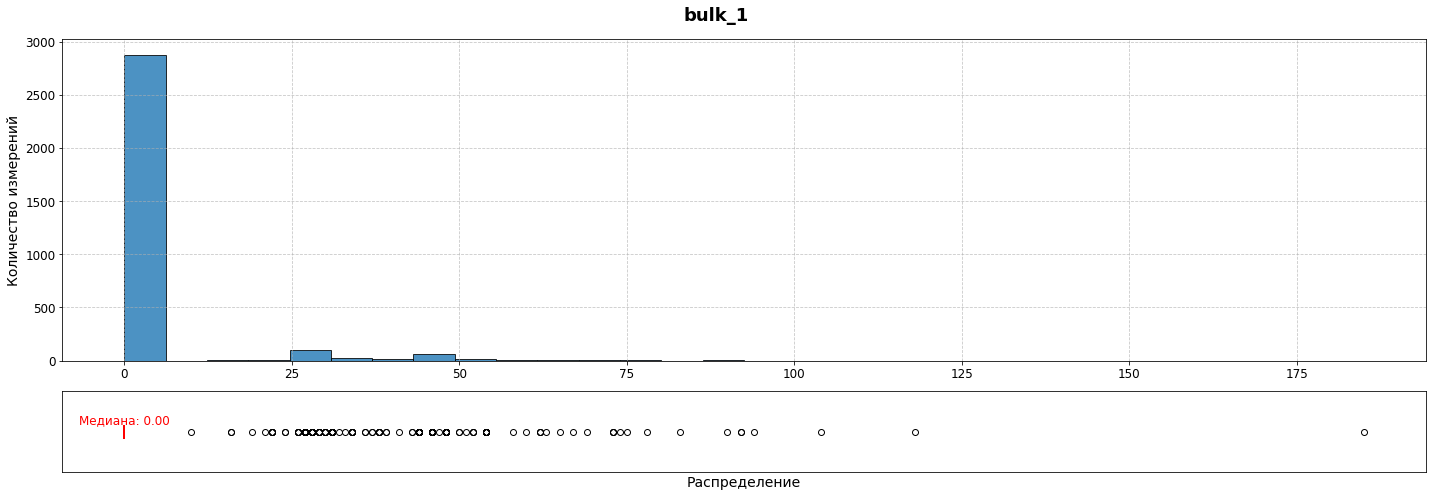

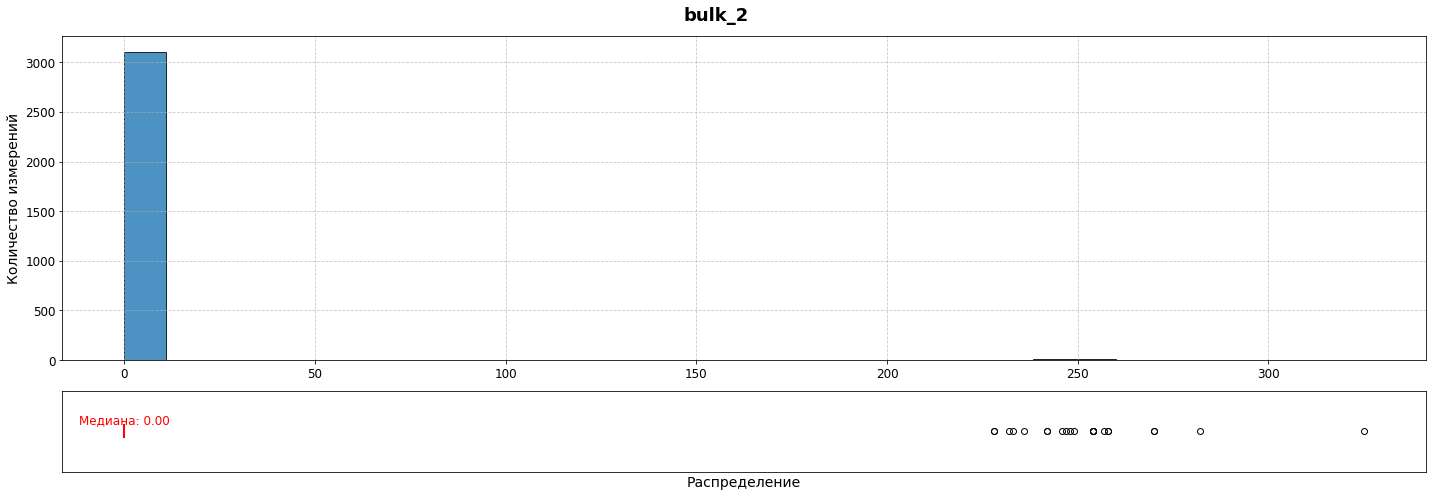

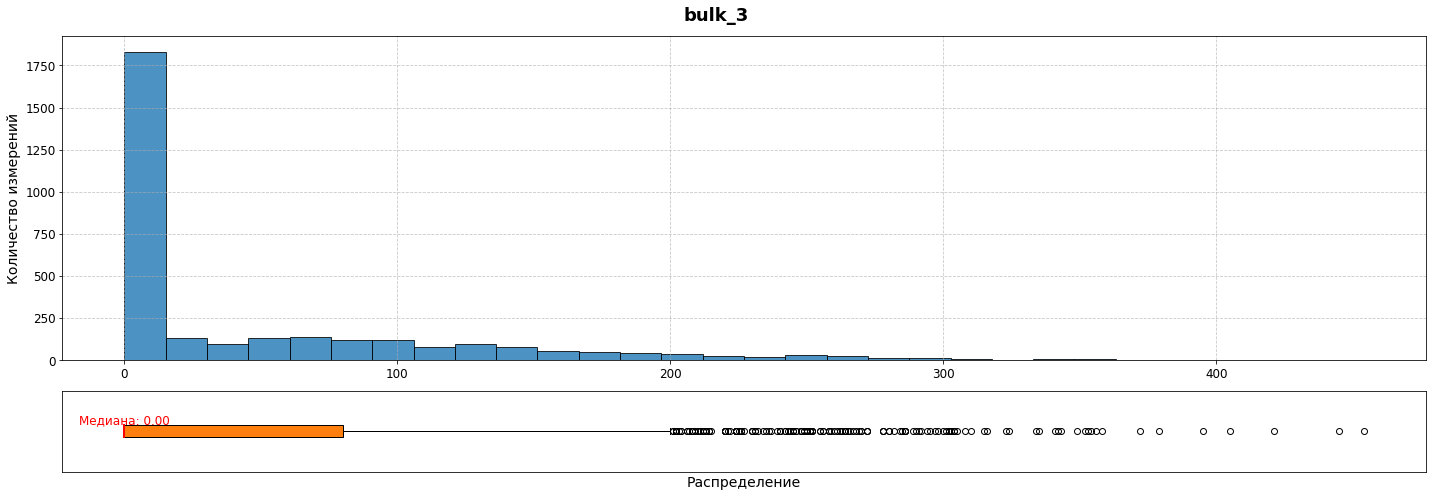

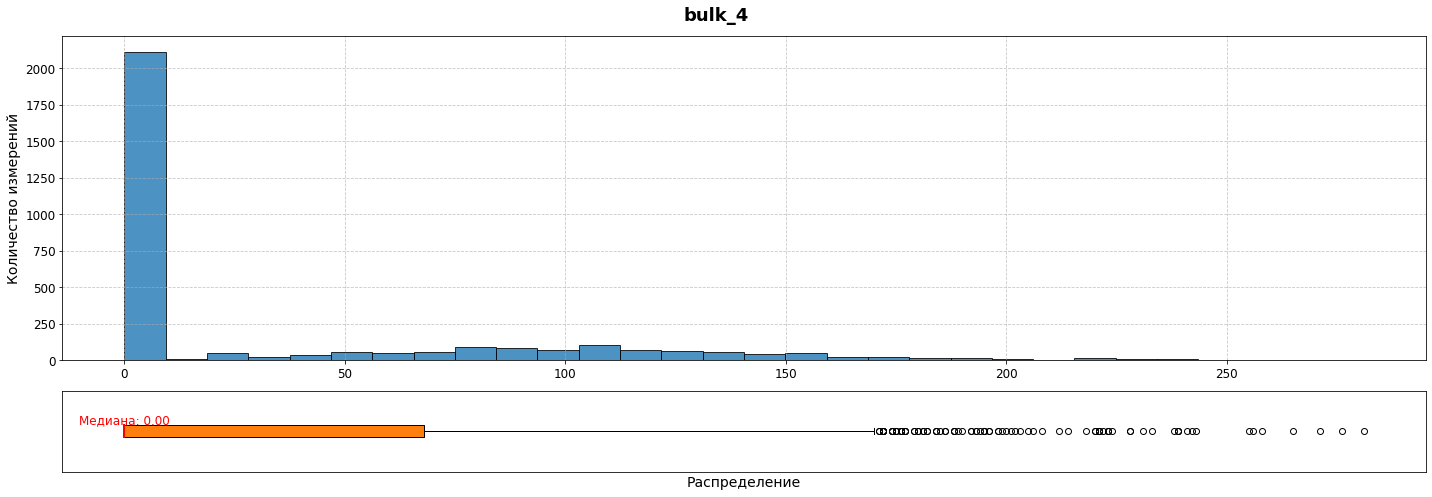

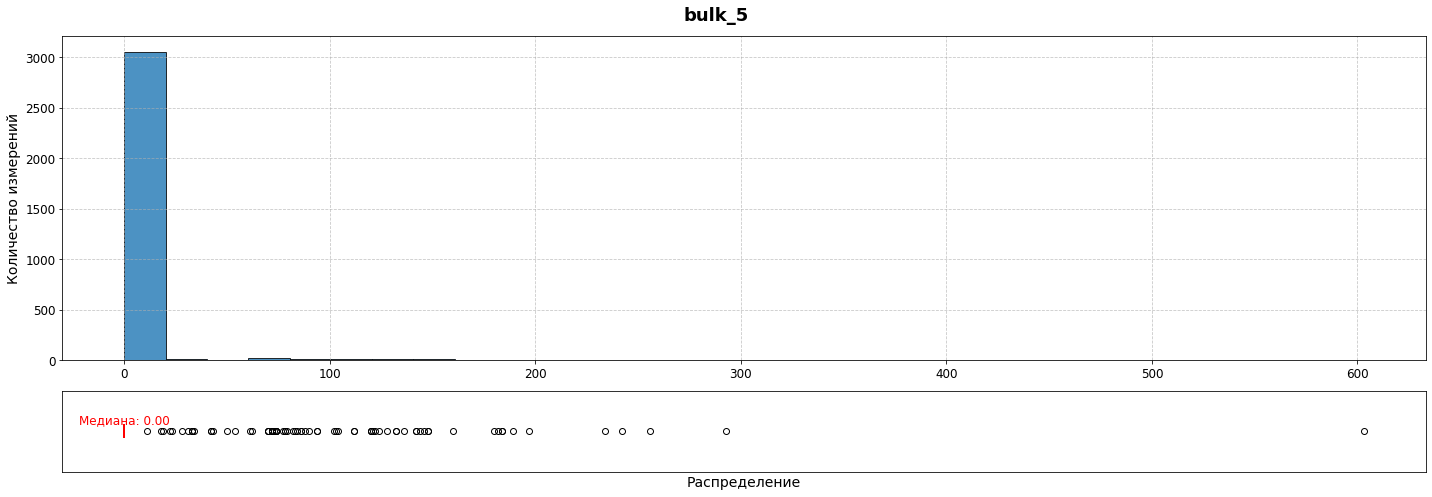

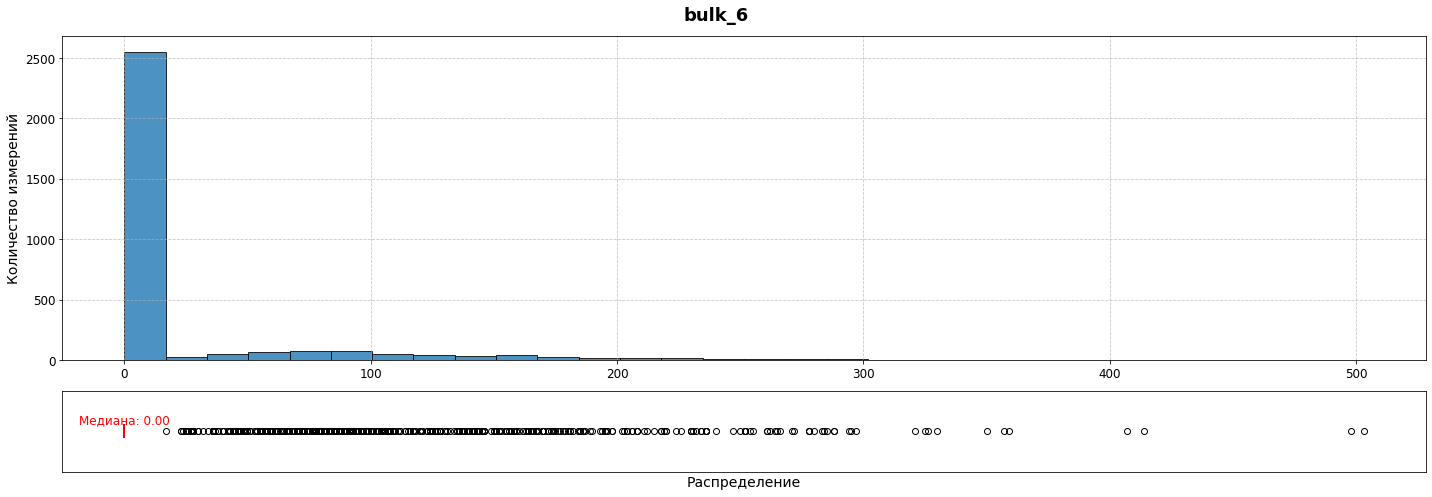

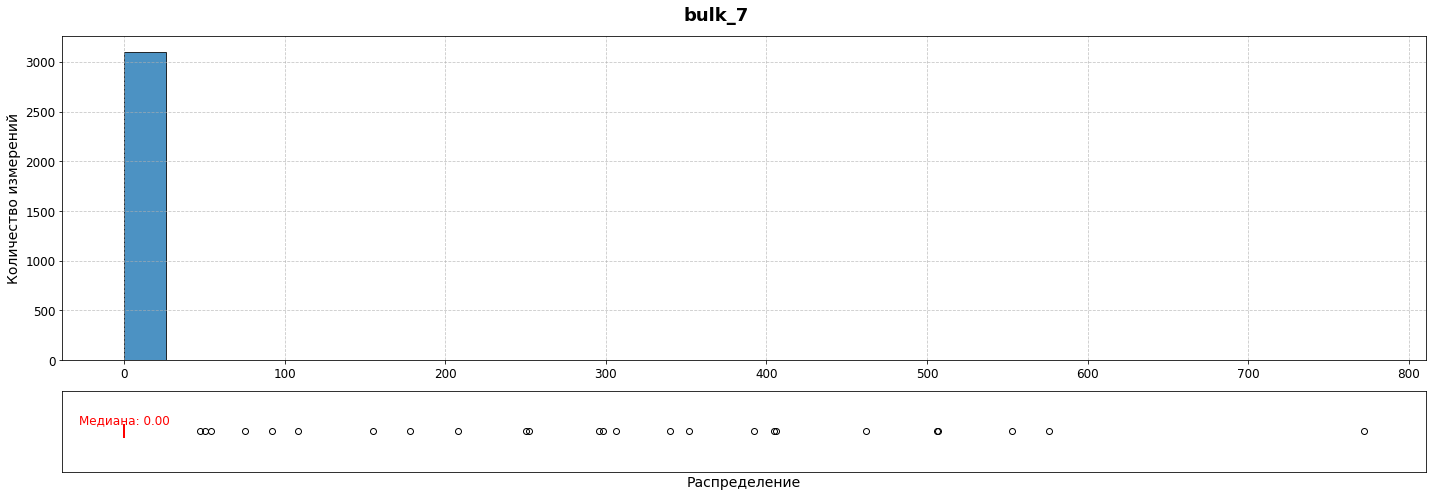

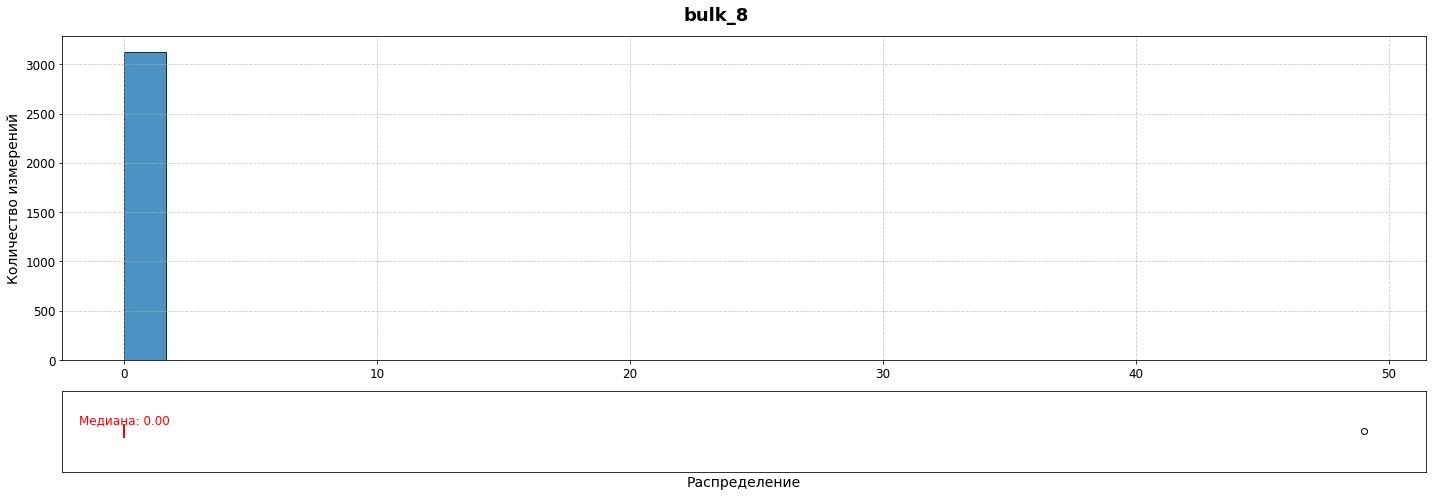

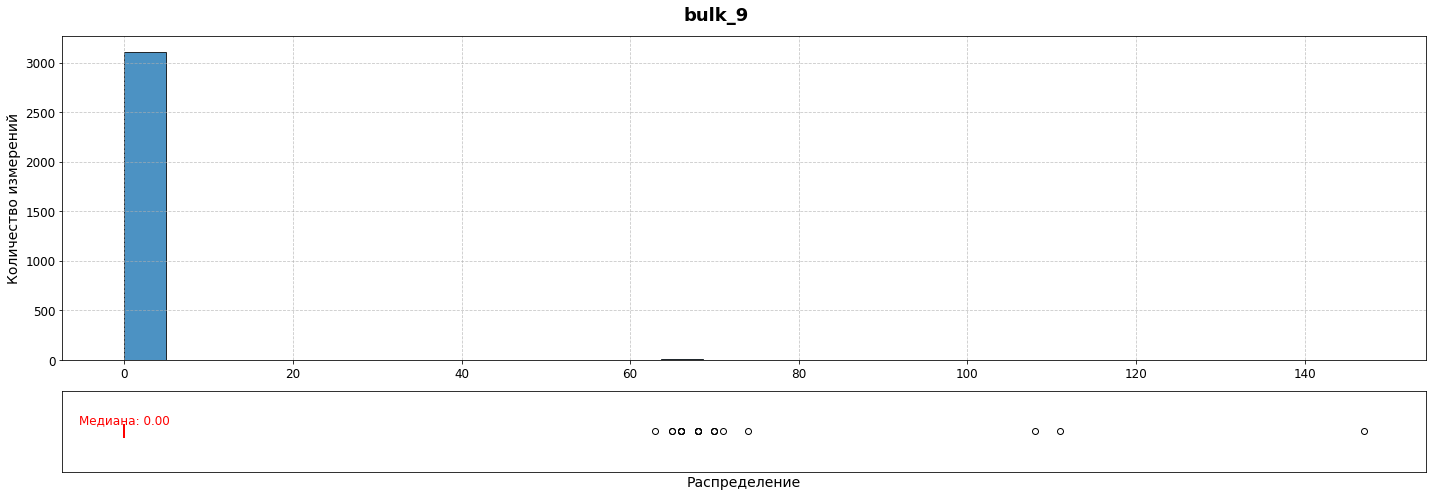

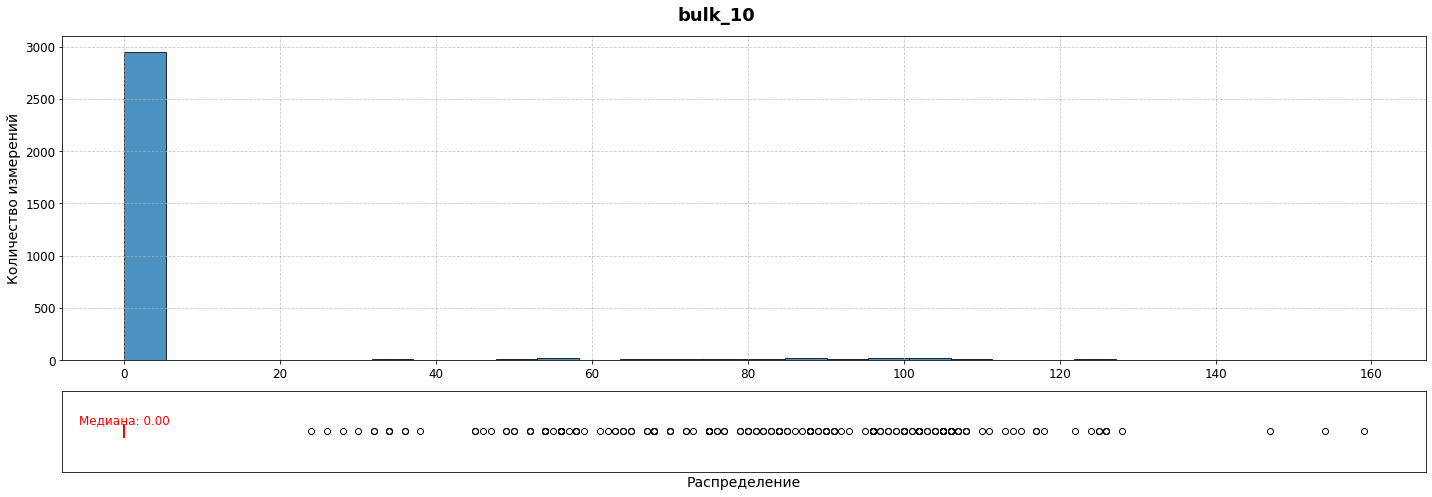

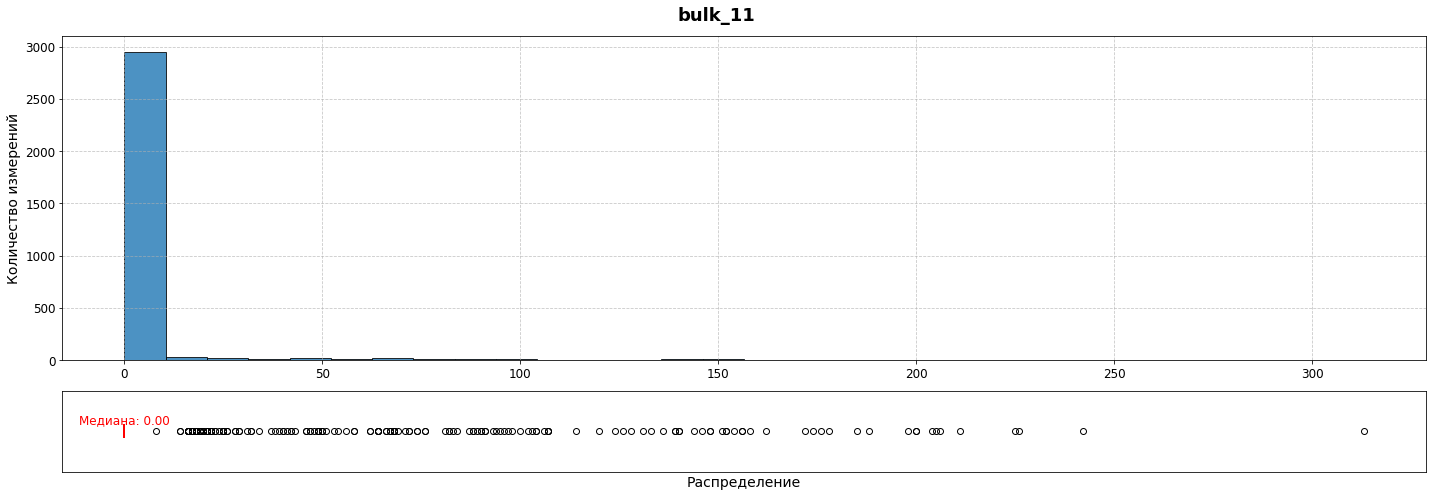

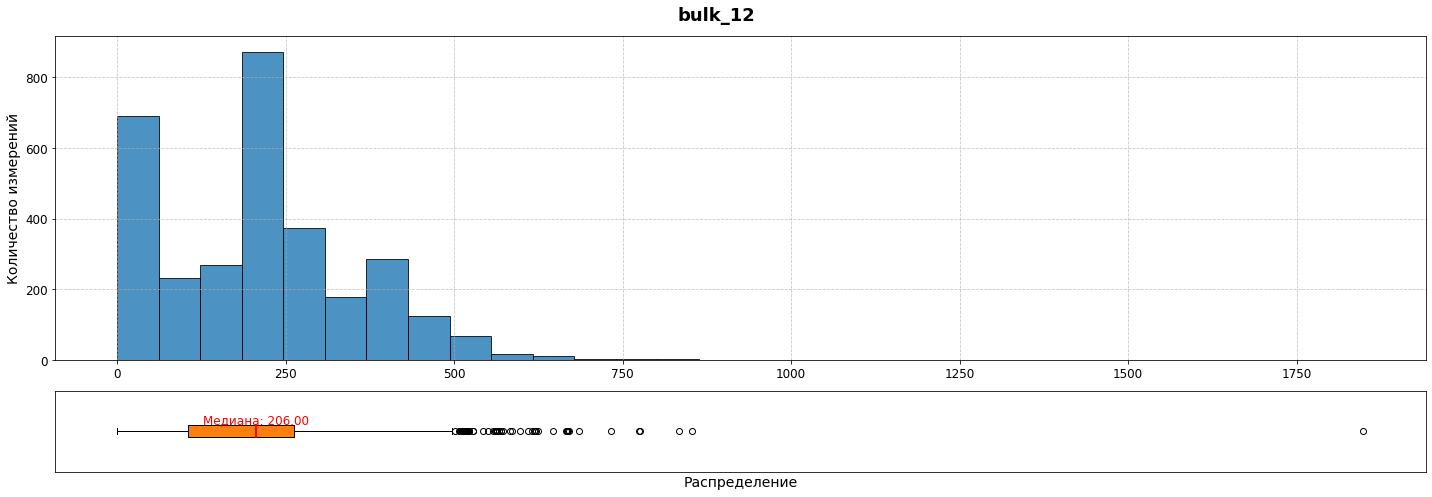

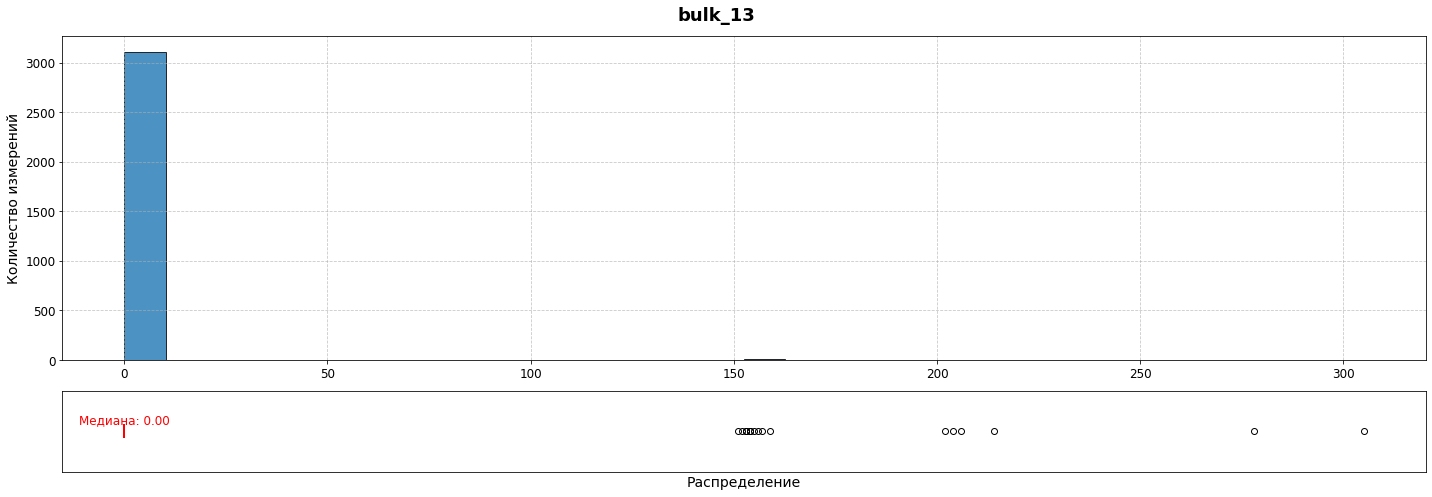

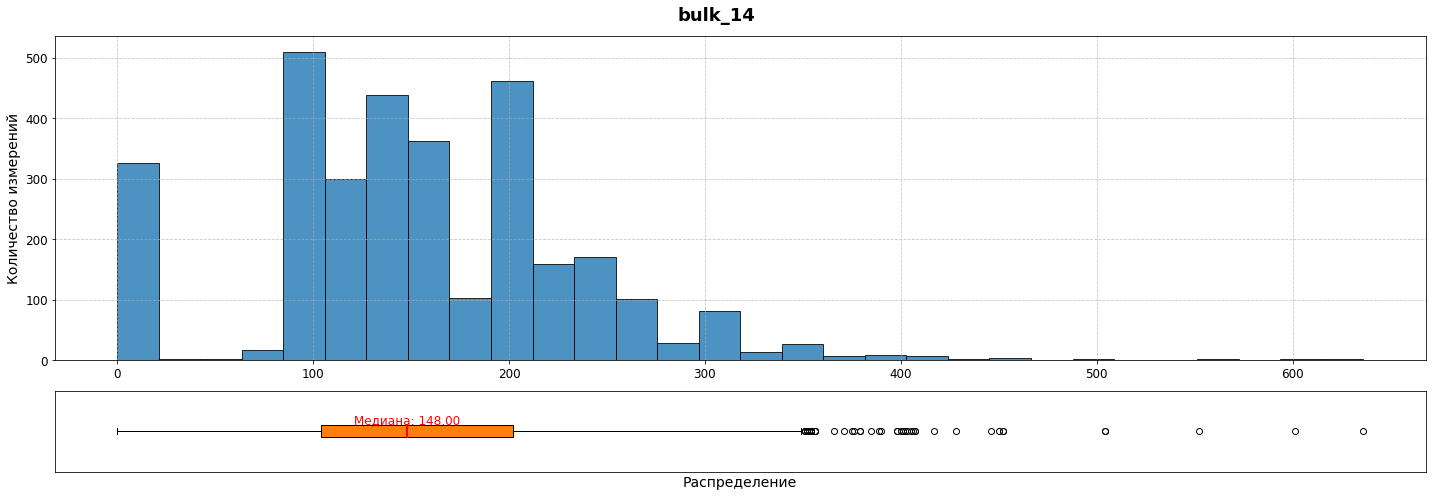

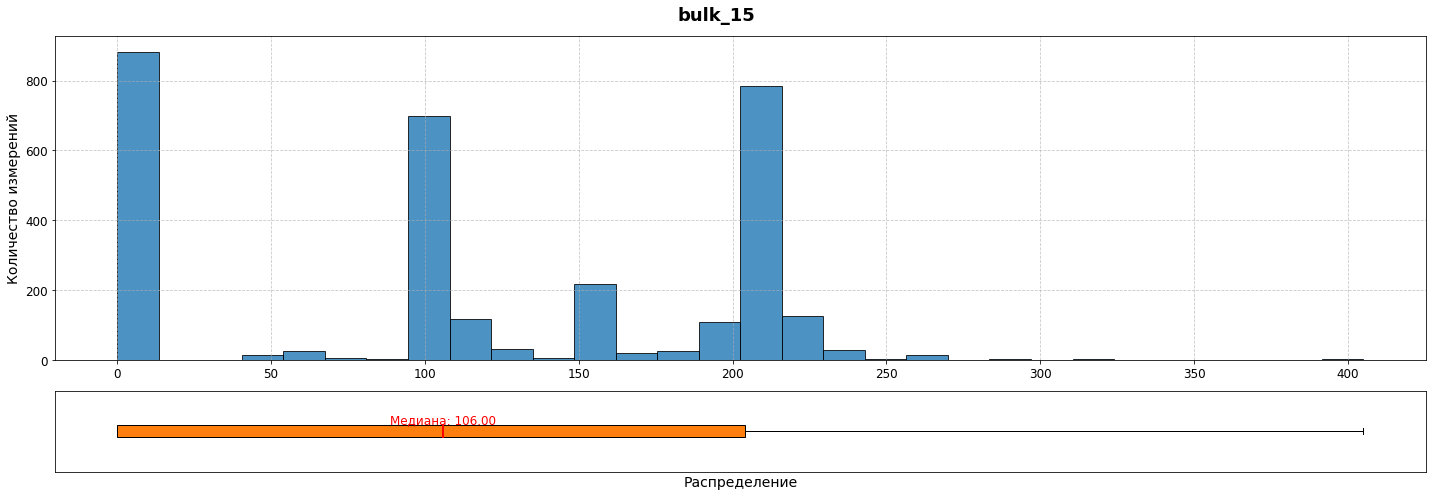

In [11]:
titles = bulk_columns  # Используем названия столбцов как заголовки
xlabels = ['Распределение'] * len(bulk_columns)  # Создаем список с одинаковыми подписями осей X

# Вызываем функцию plot_numeric
plot_numeric(
    bulk,
    variables=bulk_columns,  # Передаем список столбцов
    titles=titles,           # Передаем список заголовков
    xlabels=xlabels          # Передаем список подписей осей X
)


**Фрейм data_bulk_time_new.csv**

In [12]:
bulk_time = transform_columns(bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
Явных дублей: 0

Пропущ

bulk_8     100.0
bulk_9      99.4
bulk_13     99.4
bulk_2      99.3
bulk_7      99.2
bulk_5      97.5
bulk_10     94.4
bulk_11     94.3
bulk_1      91.9
bulk_6      81.6
bulk_4      67.6
bulk_3      58.5
bulk_15     28.2
bulk_12     21.7
bulk_14     10.3
key          0.0
dtype: float64


INFO:


None


DESCRIBE:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



HEAD:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


**Фрейм data_gas_new.csv**

In [13]:
gas = transform_columns(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Явных дублей: 0

Пропущенных значений (%):


key      0.0
газ_1    0.0
dtype: float64


INFO:


None


DESCRIBE:


,key,газ_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



HEAD:


,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


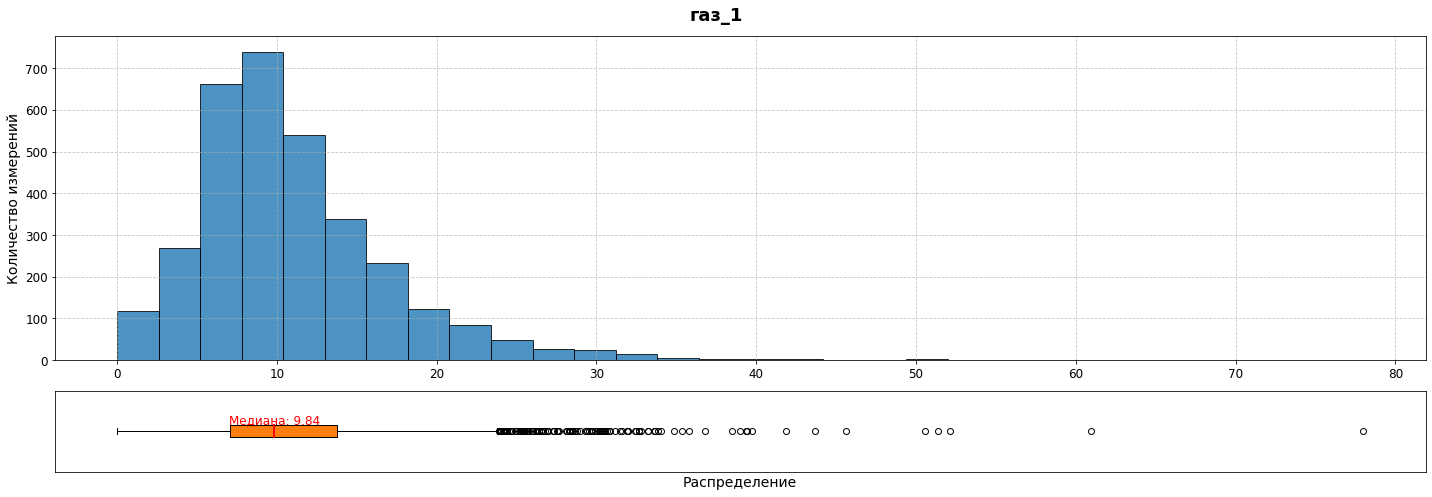

In [14]:
plot_numeric(
    gas,
    variables=['газ_1'],
    titles=['газ_1'],
    xlabels=['Распределение']
)

В данных наблюдается значительный разрыв между 75%-м квантилем (третьим квартилем, Q3) и максимальным значением. Но это не похоже на выбросы. Также есть значения минимальные, что свидетельствует о том, что газ возможно вообще не подавался

**Фрейм data_temp_new.csv**

In [15]:
temperature = transform_columns(temperature)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
Явных дублей: 0

Пропущенных значений (%):


температура     18.9
key              0.0
время_замера     0.0
dtype: float64


INFO:


None


DESCRIBE:


,key,температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



HEAD:


,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [16]:
#Удалим пропущенные значения, тем более далее этот показатель и будет являться целевым
temperature = temperature.dropna()

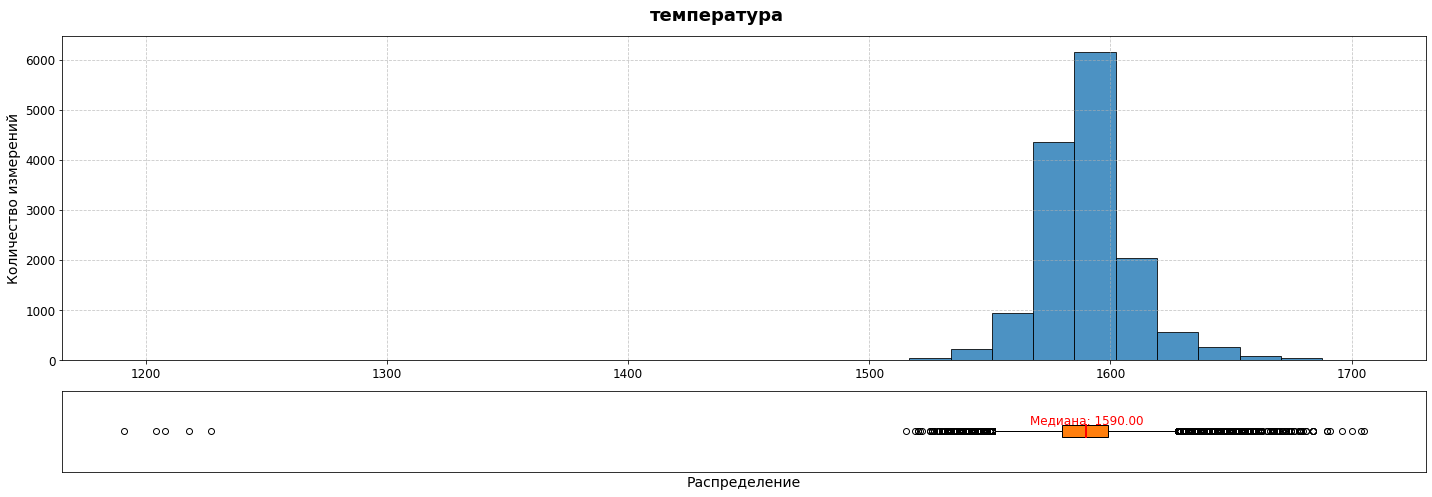

In [17]:
plot_numeric(
    temperature,
    variables=['температура'],
    titles=['температура'],
    xlabels=['Распределение']
)

In [18]:
#Удалим явные выбросы
temperature = temperature[temperature['температура'] > 1500]
temperature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14660 non-null  int64         
 1   время_замера  14660 non-null  datetime64[ns]
 2   температура   14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


Необходимо спрогнозировать последнее измерение температуры для каждой партии. Для этого важно, чтобы количество замеров температуры в каждой партии было больше одного. Мы сгруппируем данные по уникальному ключу партии и отфильтруем их, оставив только те партии, где температура измерялась более двух раз. Это связано с тем, что партии с одним или двумя измерениями не подходят для решения задачи, а значимый рост количества измерений начинается с трех.

Основная цель — оптимизировать снижение энергопотребления, поэтому первые два измерения температуры будут использоваться в качестве признаков, а последнее измерение — в качестве целевой переменной.

Мы сохраним только те партии, где количество измерений температуры превышает два, и создадим новые колонки:
- Первое измерение температуры,
- Второе измерение температуры,
- Последнее измерение температуры (целевая переменная).

Таким образом, данные будут подготовлены для дальнейшего анализа и построения модели прогнозирования.

In [19]:
temperature = temperature.groupby('key').agg(time_first = ('время_замера','first'),\
                             time_last = ('время_замера','last'), \
                             temperature_list=('температура', list), count_temp = ('температура', 'count')).reset_index()

In [20]:
# Оставляем только те строки, где количество измерений температуры больше 2
temperature = temperature[temperature['count_temp'] > 2]

# Создаем новые колонки:
# - temperature_first: первое измерение температуры
# - temperature_second: второе измерение температуры
# - temperature: последнее измерение температуры (целевая переменная)
temperature['temperature_first'] = temperature['temperature_list'].apply(lambda x: x[0])
temperature['temperature_second'] = temperature['temperature_list'].apply(lambda x: x[1])
temperature['temperature'] = temperature['temperature_list'].apply(lambda x: x[-1])

temperature.head()

,key,time_first,time_last,temperature_list,count_temp,temperature_first,temperature_second,temperature
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,"[1571.0, 1604.0, 1618.0, 1601.0, 1606.0, 1613.0]",6,1571.0,1604.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,"[1581.0, 1577.0, 1589.0, 1604.0, 1602.0]",5,1581.0,1577.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,"[1596.0, 1597.0, 1598.0, 1599.0, 1600.0, 1599.0]",6,1596.0,1597.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,"[1601.0, 1623.0, 1618.0, 1617.0, 1625.0]",5,1601.0,1623.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,"[1576.0, 1592.0, 1589.0, 1586.0, 1602.0]",5,1576.0,1592.0,1602.0


**Фрейм data_wire_new.csv**

In [21]:
wire = transform_columns(wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Явных дублей: 0

Пропущенных значений (%):


wire_5    100.0
wire_7     99.6
wire_4     99.5
wire_8     99.4
wire_9     99.1
wire_3     98.0
wire_6     97.6
wire_2     65.0
wire_1      0.8
key         0.0
dtype: float64


INFO:


None


DESCRIBE:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



HEAD:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Заменяем NaN на 0 в столбцах wire_1, wire_2, ..., wire_9
wire_columns = [f'wire_{i}' for i in range(1, 9)]  # Список столбцов
wire[wire_columns] = wire[wire_columns].fillna(0)

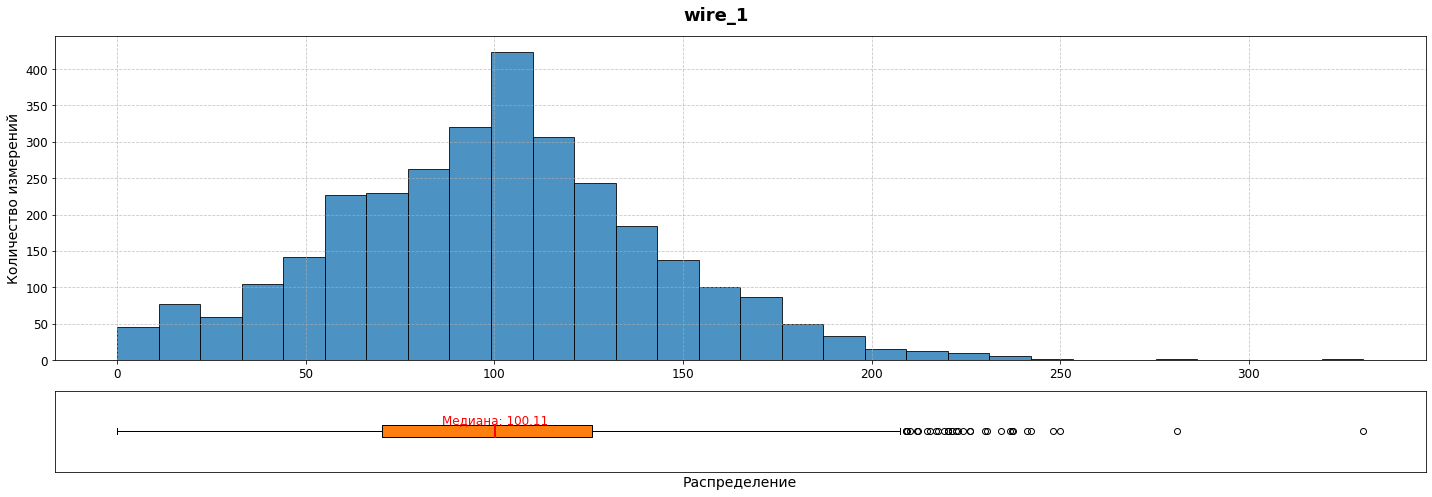

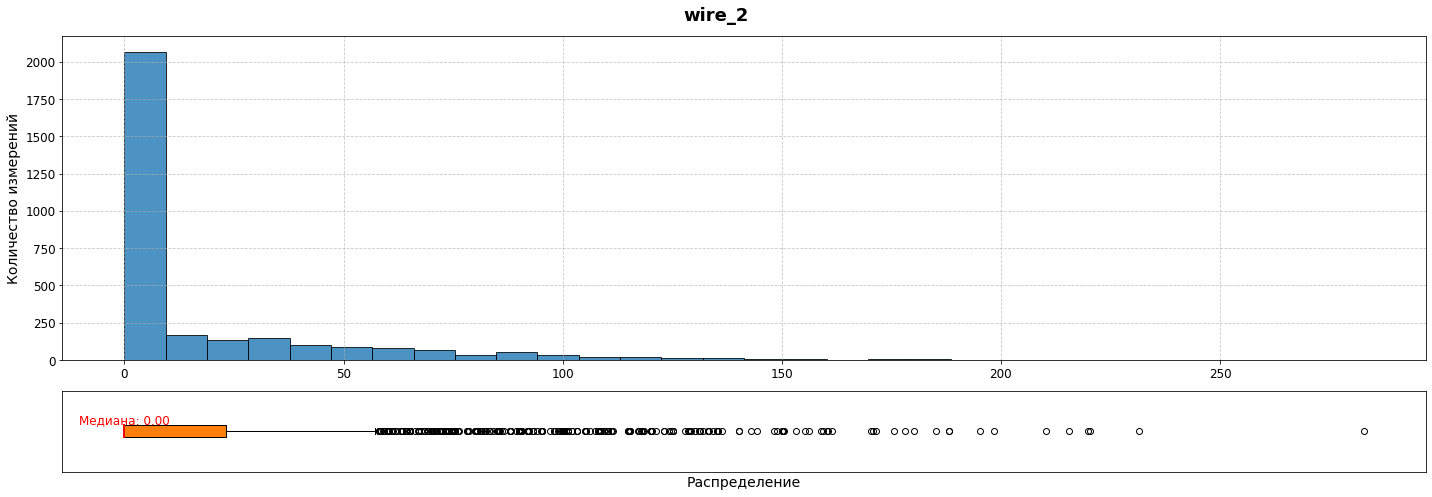

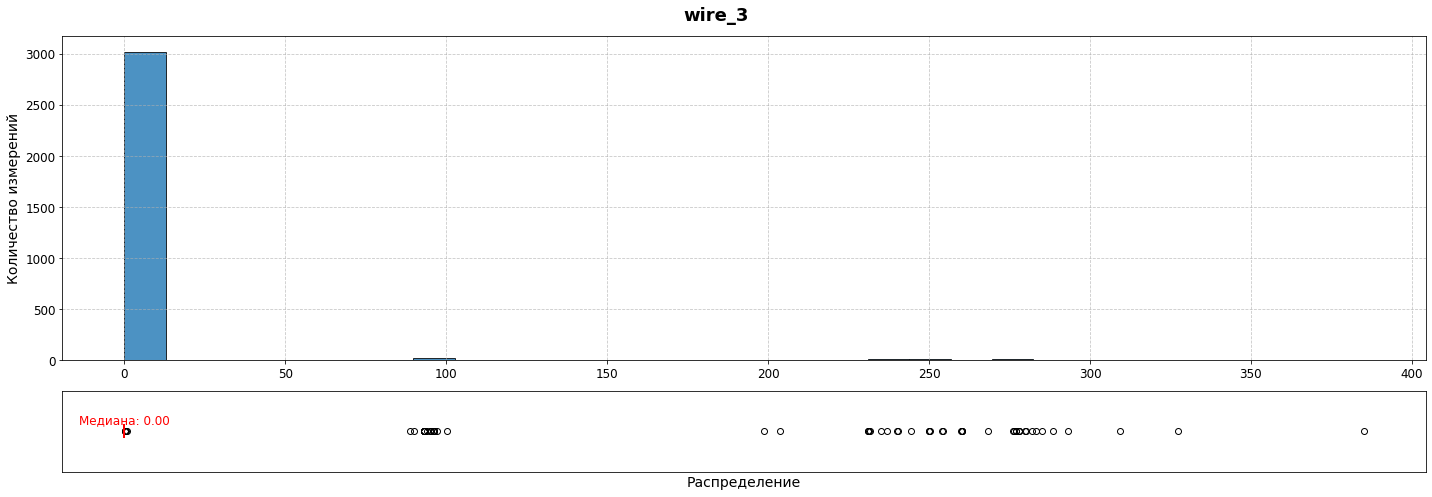

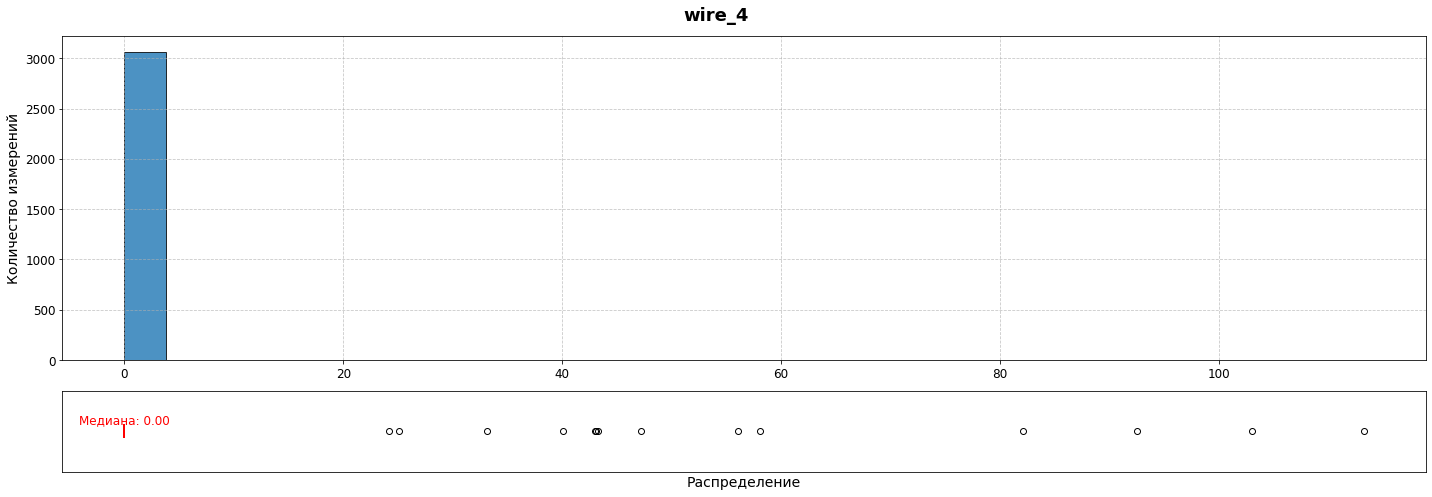

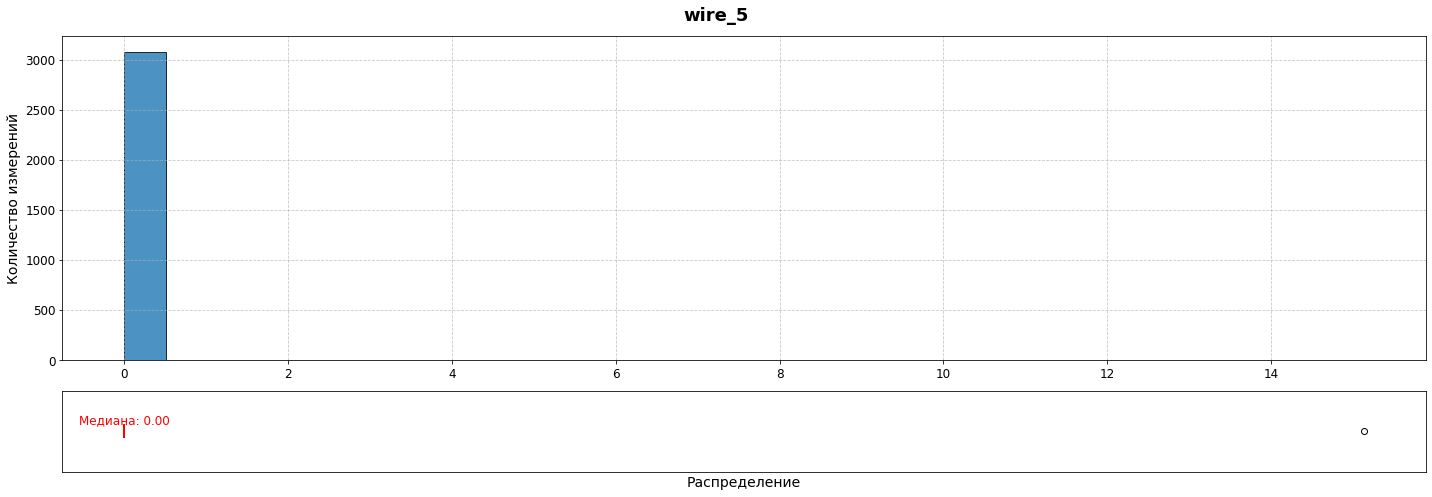

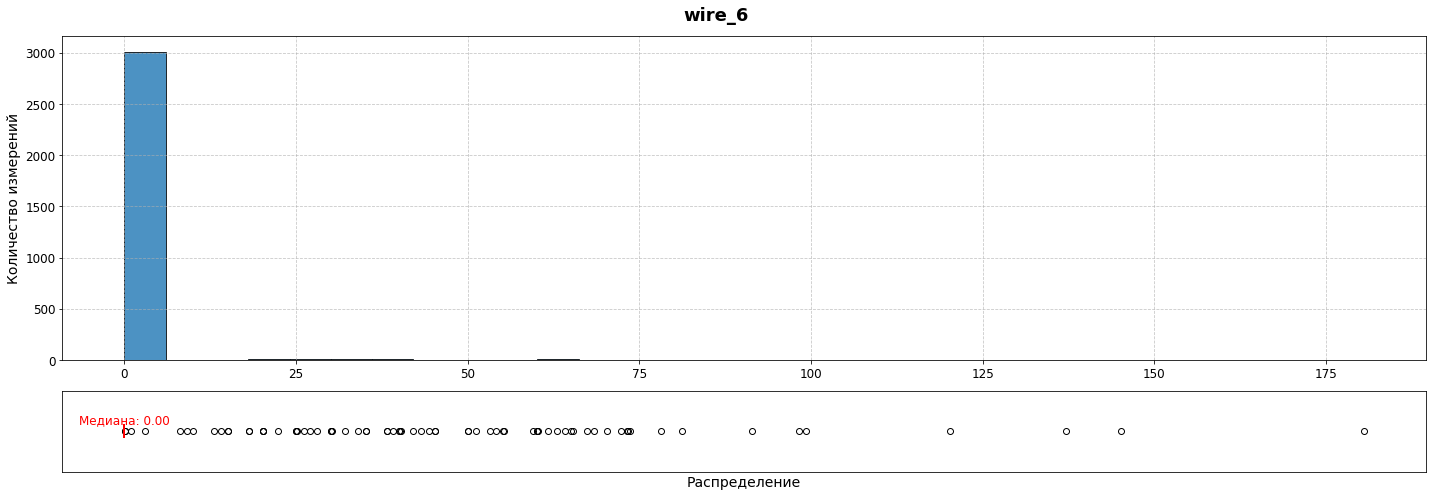

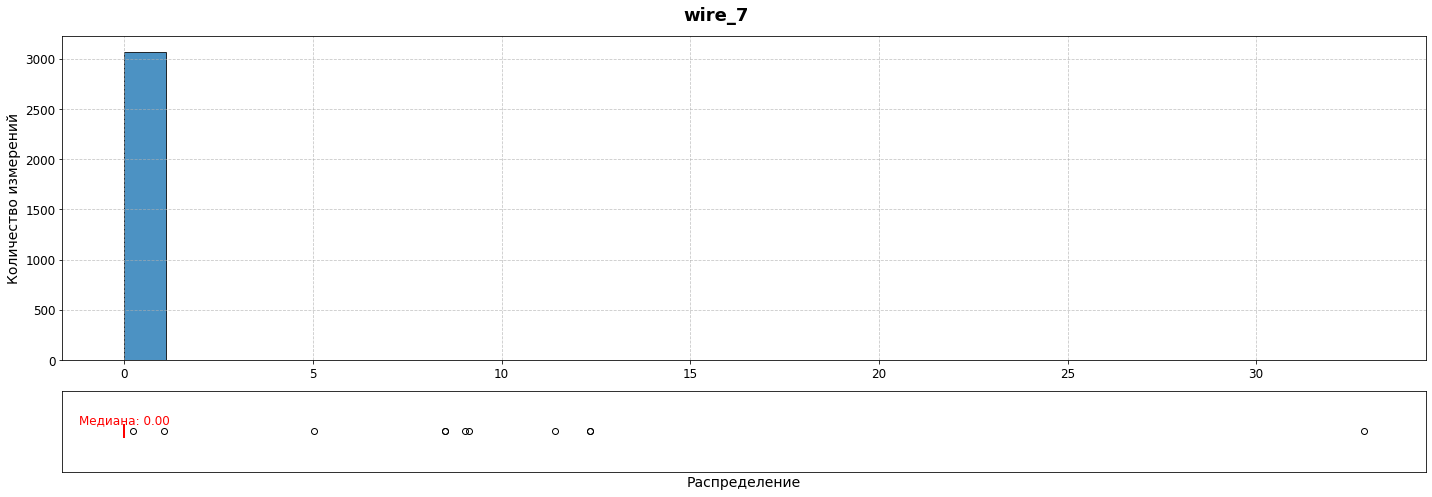

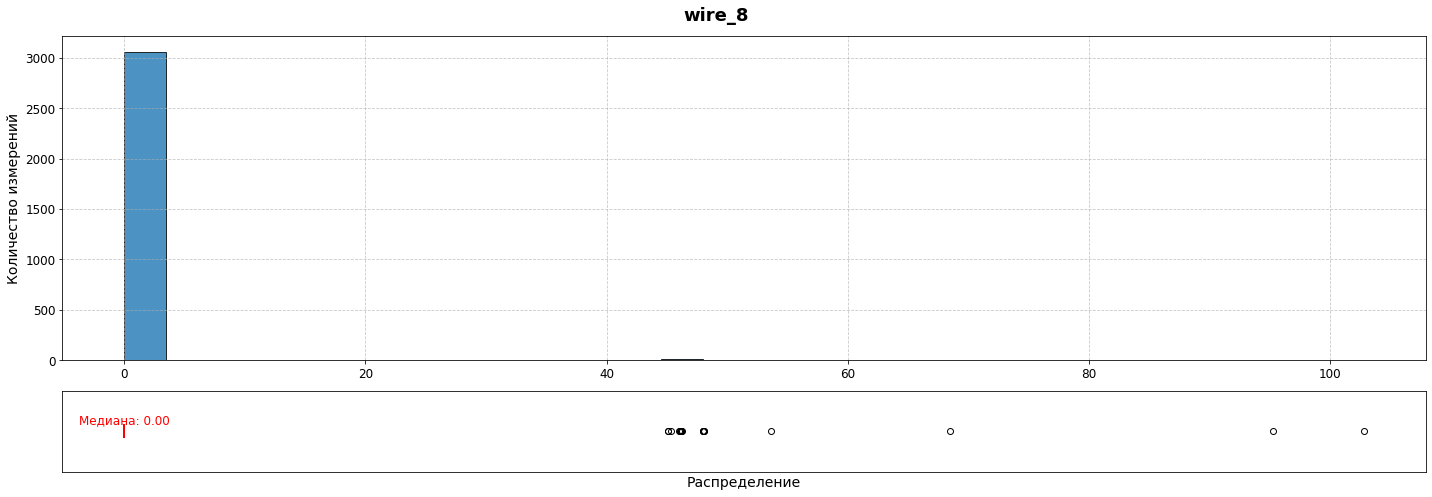

In [23]:
titles = wire_columns  # Используем названия столбцов как заголовки
xlabels = ['Распределение'] * len(wire_columns)  # Создаем список с одинаковыми подписями осей X

# Вызываем функцию plot_numeric
plot_numeric(
    wire,
    variables=wire_columns,  # Передаем список столбцов
    titles=titles,           # Передаем список заголовков
    xlabels=xlabels          # Передаем список подписей осей X
)


**Фрейм data_wire_time_new.csv**

In [24]:
wire_time = transform_columns(wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
Явных дублей: 0

Пропущенных значений (%):


wire_5    100.0
wire_7     99.6
wire_4     99.5
wire_8     99.4
wire_9     99.1
wire_3     98.0
wire_6     97.6
wire_2     65.0
wire_1      0.8
key         0.0
dtype: float64


INFO:


None


DESCRIBE:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



HEAD:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Вернемся к фрейму data_arc_new.csv и доработаем его, выведем полную мощность**

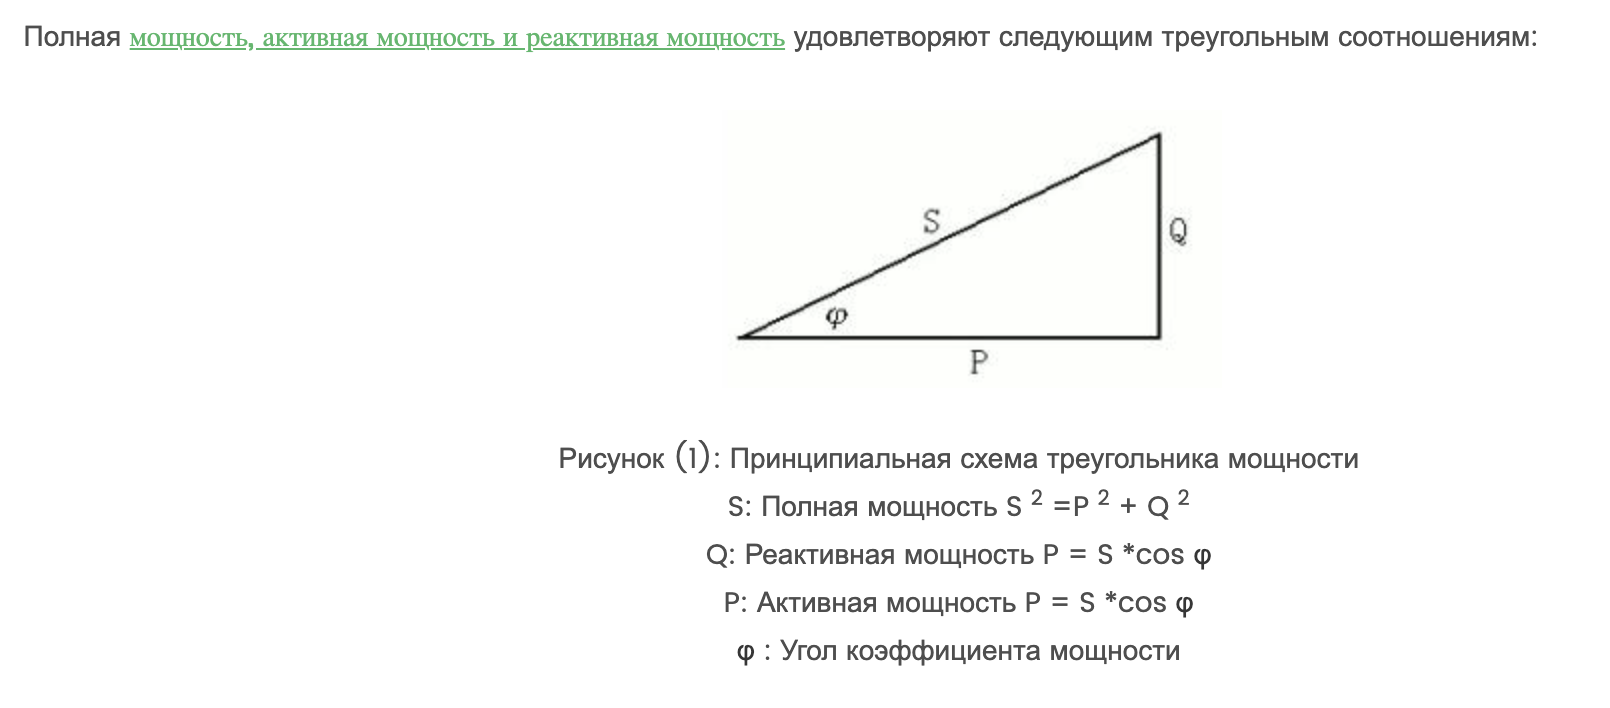

In [25]:
# Вычисление коэффициента мощности (power ratio)
arc['power_ratio'] = arc['активная_мощность'] / np.hypot(arc['активная_мощность'], arc['реактивная_мощность'])

# Вычисление времени нагрева (time_of_heating)
arc['time_of_heating'] = pd.to_timedelta(arc['конец_нагрева_дугой'] - arc['начало_нагрева_дугой'])

# Преобразование времени нагрева в секунды (time_in_seconds)
arc['time_in_seconds'] = arc['time_of_heating'].dt.total_seconds()

In [26]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   key                   14875 non-null  int64          
 1   начало_нагрева_дугой  14875 non-null  datetime64[ns] 
 2   конец_нагрева_дугой   14875 non-null  datetime64[ns] 
 3   активная_мощность     14875 non-null  float64        
 4   реактивная_мощность   14875 non-null  float64        
 5   power_ratio           14875 non-null  float64        
 6   time_of_heating       14875 non-null  timedelta64[ns]
 7   time_in_seconds       14875 non-null  float64        
dtypes: datetime64[ns](2), float64(4), int64(1), timedelta64[ns](1)
memory usage: 1.0 MB


In [27]:
# Группируем данные по ключу партии ('key') и агрегируем результаты
arc = arc.groupby('key').agg(
    start_heating_tm=('начало_нагрева_дугой', 'first'),  # Время начала первого нагрева
    end_heating_tm=('конец_нагрева_дугой', 'last'),      # Время окончания последнего нагрева
    active_p=('активная_мощность', 'mean'),                  # Средняя активная мощность
    reactive_p=('реактивная_мощность', 'mean'),              # Средняя реактивная мощность
    power_ratio=('power_ratio', 'sum'),             # Суммарный коэффициент мощности
    time_of_heating=('time_of_heating', 'sum')      # Суммарное время нагрева
).reset_index()

arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   key               3214 non-null   int64          
 1   start_heating_tm  3214 non-null   datetime64[ns] 
 2   end_heating_tm    3214 non-null   datetime64[ns] 
 3   active_p          3214 non-null   float64        
 4   reactive_p        3214 non-null   float64        
 5   power_ratio       3214 non-null   float64        
 6   time_of_heating   3214 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), timedelta64[ns](1)
memory usage: 175.9 KB


In [28]:
arc.head()

,key,start_heating_tm,end_heating_tm,active_p,reactive_p,power_ratio,time_of_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,4.083428,0 days 00:18:18
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,3.301105,0 days 00:13:31
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,4.048621,0 days 00:10:55
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,3.175691,0 days 00:12:21
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,3.187274,0 days 00:14:29


**Промежуточный итог**

- Загрузили данные (Данные успешно загружены, проверена их структура (количество строк, колонок, типы данных).

- Визуально оценили данные
  - Проведен первичный анализ данных с использованием визуализации
  - Получено понимание структуры данных, выявлены аномалии и пропуски.

- Избавились от выбросов
  - Выбросы были идентифицированы с использованием статистических методов 
  - Данные очищены от выбросов, что улучшило их качество.

- Заполнили пропуски
  - Пропущенные значения (NaN) были заполнены

- Данные готовы для следующих шагов

# Объединим таблицы 

Приступим к объединению данных из таблицы с целевым признаком

In [29]:
data = [arc, bulk, bulk_time, gas, wire, wire_time]
data_for_merge = temperature

# Объединение всех DataFrame за один шаг
data = reduce(lambda left, right: left.merge(right, on='key', how='inner'), data, data_for_merge)

display(data)

,key,time_first,time_last,temperature_list,count_temp,temperature_first,temperature_second,temperature,start_heating_tm,end_heating_tm,...,wire_9_x,wire_1_y,wire_2_y,wire_3_y,wire_4_y,wire_5_y,wire_6_y,wire_7_y,wire_8_y,wire_9_y
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,"[1571.0, 1604.0, 1618.0, 1601.0, 1606.0, 1613.0]",6,1571.0,1604.0,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,...,NaN,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,"[1581.0, 1577.0, 1589.0, 1604.0, 1602.0]",5,1581.0,1577.0,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,...,NaN,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,"[1596.0, 1597.0, 1598.0, 1599.0, 1600.0, 1599.0]",6,1596.0,1597.0,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,...,NaN,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,"[1601.0, 1623.0, 1618.0, 1617.0, 1625.0]",5,1601.0,1623.0,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,...,NaN,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,"[1576.0, 1592.0, 1589.0, 1586.0, 1602.0]",5,1576.0,1592.0,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,...,NaN,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,"[1570.0, 1590.0, 1580.0, 1585.0, 1591.0]",5,1570.0,1590.0,1591.0,2019-08-10 11:27:57,2019-08-10 11:48:05,...,NaN,2019-08-10 11:31:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2299,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,"[1554.0, 1576.0, 1595.0, 1583.0, 1584.0, 1580....",7,1554.0,1576.0,1591.0,2019-08-10 11:56:58,2019-08-10 12:23:07,...,NaN,2019-08-10 11:59:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2300,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,"[1571.0, 1577.0, 1576.0, 1589.0]",4,1571.0,1577.0,1589.0,2019-08-10 12:37:36,2019-08-10 12:51:20,...,NaN,2019-08-10 12:46:10,2019-08-10 12:40:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2301,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,"[1591.0, 1570.0, 1580.0, 1593.0, 1582.0, 1594.0]",6,1591.0,1570.0,1594.0,2019-08-10 12:58:21,2019-08-10 13:20:59,...,NaN,2019-08-10 13:02:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [30]:
data['time_of_heating_seconds'] = data['time_of_heating'].dt.total_seconds().astype('float64')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   key                      2303 non-null   int64          
 1   time_first               2303 non-null   datetime64[ns] 
 2   time_last                2303 non-null   datetime64[ns] 
 3   temperature_list         2303 non-null   object         
 4   count_temp               2303 non-null   int64          
 5   temperature_first        2303 non-null   float64        
 6   temperature_second       2303 non-null   float64        
 7   temperature              2303 non-null   float64        
 8   start_heating_tm         2303 non-null   datetime64[ns] 
 9   end_heating_tm           2303 non-null   datetime64[ns] 
 10  active_p                 2303 non-null   float64        
 11  reactive_p               2303 non-null   float64        
 12  power_ratio         

Удалим колонки с датами, количеством измерений, временную колонку, номера партий

In [32]:
cols_to_keep = [ 
    "active_p", "reactive_p", "temperature", "temperature_first",
    "power_ratio", "time_of_heating_seconds", 
    "bulk_1_x", "bulk_2_x", "bulk_3_x", "bulk_4_x", "bulk_5_x", "bulk_6_x", "bulk_7_x", 
    "bulk_8_x", "bulk_9_x", "bulk_10_x", "bulk_11_x", "bulk_12_x", "bulk_13_x", "bulk_14_x", "bulk_15_x",
    "газ_1", 
    "wire_1_x", "wire_2_x", "wire_3_x", "wire_4_x", "wire_5_x", "wire_6_x", "wire_7_x", 
    "wire_8_x", "wire_9_x"
]

# Оставляем только нужные колонки
data = data[cols_to_keep]

display(data)

,active_p,reactive_p,temperature,temperature_first,power_ratio,time_of_heating_seconds,bulk_1_x,bulk_2_x,bulk_3_x,bulk_4_x,...,газ_1,wire_1_x,wire_2_x,wire_3_x,wire_4_x,wire_5_x,wire_6_x,wire_7_x,wire_8_x,wire_9_x
0,0.607346,0.428564,1613.0,1571.0,4.083428,1098.0,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.534852,0.363339,1602.0,1581.0,3.301105,811.0,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.812728,0.587491,1599.0,1596.0,4.048621,655.0,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.676622,0.514248,1625.0,1601.0,3.175691,741.0,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.563238,0.421998,1602.0,1576.0,3.187274,869.0,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,0.792033,0.552734,1591.0,1570.0,3.250906,723.0,0.0,0.0,21.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2299,0.695820,0.478672,1591.0,1554.0,4.917636,940.0,0.0,0.0,0.0,63.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2300,1.201746,0.817364,1589.0,1571.0,2.482839,569.0,0.0,0.0,0.0,85.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2301,0.640462,0.447964,1594.0,1591.0,4.096223,750.0,0.0,0.0,90.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN


# Корреляционный анализ

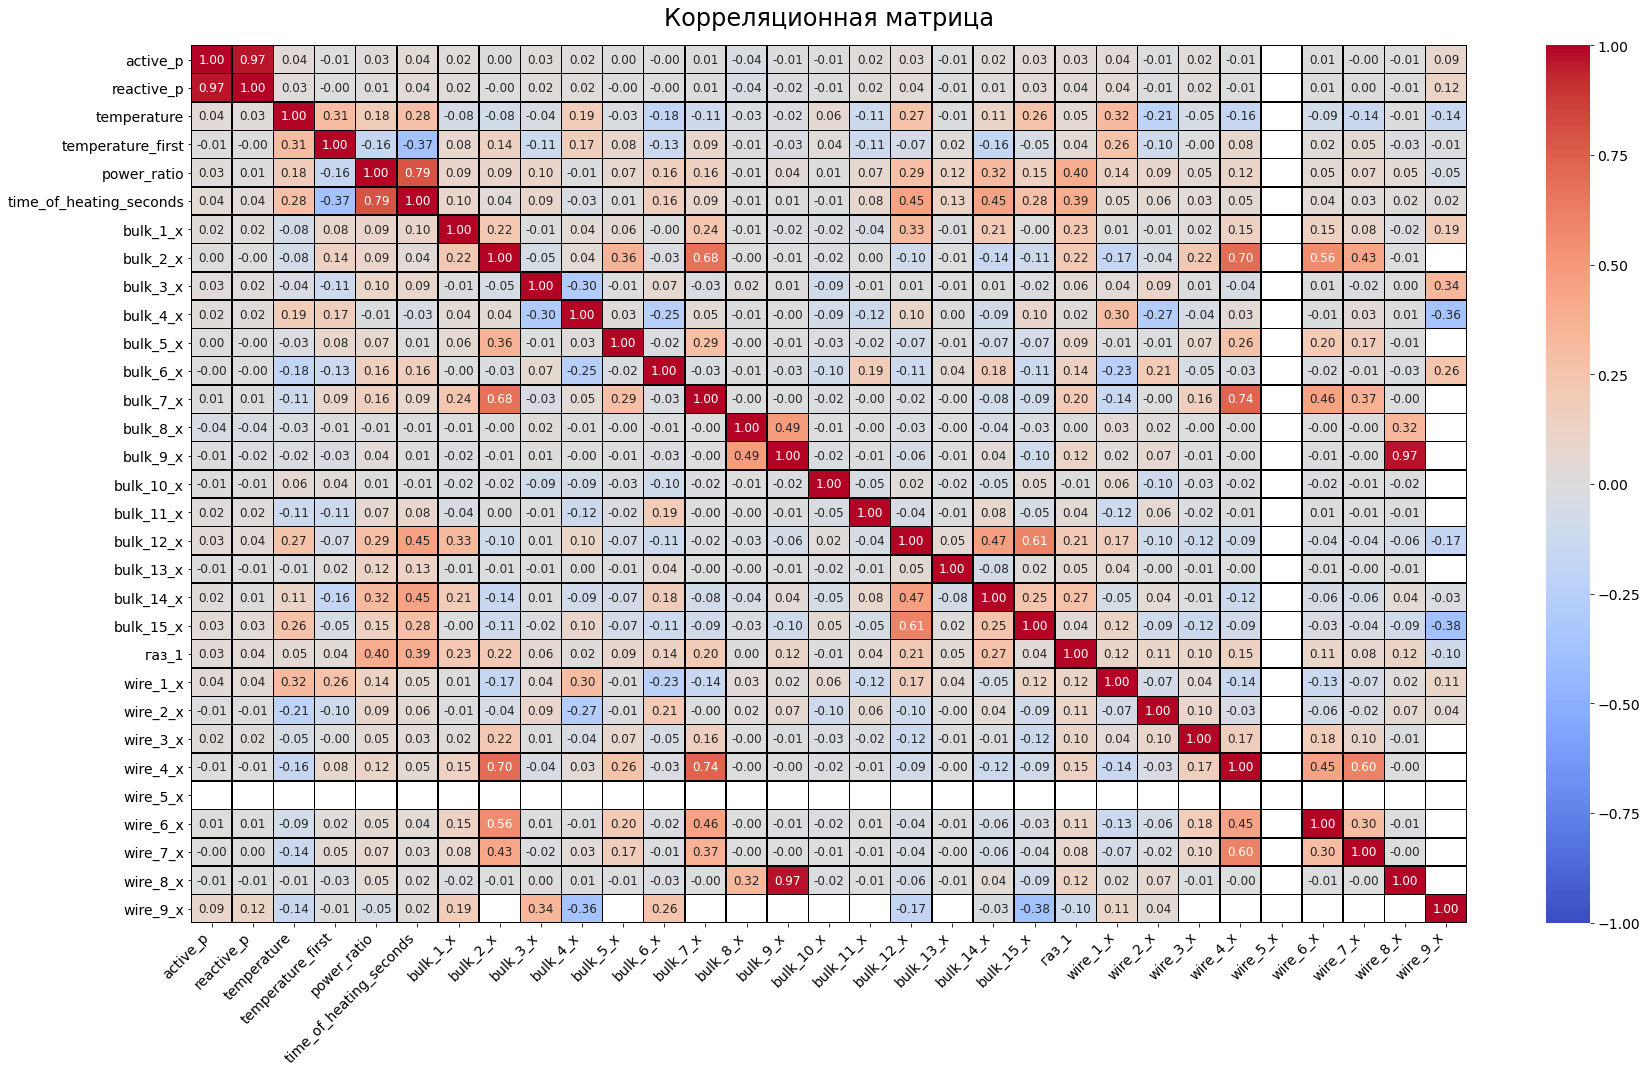

In [33]:
# Настройка размера графика 
plt.figure(figsize=(25, 15))

# Построение тепловой карты
heatmap = sns.heatmap(
    data.corr(),  # Вычисление корреляционной матрицы
    annot=True,   # Добавление числовых значений в ячейки
    cmap='coolwarm',  # Цветовая схема
    fmt=".2f",    # Формат отображения чисел (2 знака после запятой)
    linewidths=0.5,  # Толщина линий между ячейками
    linecolor='black',  # Цвет линий между ячейками
    vmin=-1, vmax=1,  # Диапазон значений для цветовой шкалы
    annot_kws={"size": 12}  # Размер шрифта для аннотаций
)

# Настройка заголовка
plt.title('Корреляционная матрица', fontsize=24, pad=20)

# Настройка подписей осей
heatmap.set_xticklabels(
    heatmap.get_xticklabels(), 
    fontsize=14,  # Увеличиваем размер шрифта для подписей оси X
    rotation=45,  # Поворачиваем подписи на 45 градусов
    ha='right'    # Выравниваем подписи по правому краю
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(), 
    fontsize=14,  # Увеличиваем размер шрифта для подписей оси Y
    rotation=0    # Не поворачиваем подписи оси Y
)

# Увеличиваем размер цветовой шкалы (colorbar)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

# Отображение графика
plt.tight_layout()  
plt.show()

Удалим следующие колонки из фрейма:
- active_p
- reactive_p
- wire_5_x
- wire_9_x

# Список колонок для удаления
columns_to_drop = ["active_p", "reactive_p", "wire_5_x", "wire_9_x", "wire_8_x", "wire_4_x", "wire_6_x", "wire_7_x", "bulk_2_x"]

# Удаляем указанные колонки
data = data.drop(columns=columns_to_drop)

In [34]:
# Список колонок для удаления
columns_to_drop = ["active_p", "reactive_p", "wire_9_x", "wire_5_x", "wire_8_x", "wire_4_x"]

# Удаляем указанные колонки
data = data.drop(columns=columns_to_drop)

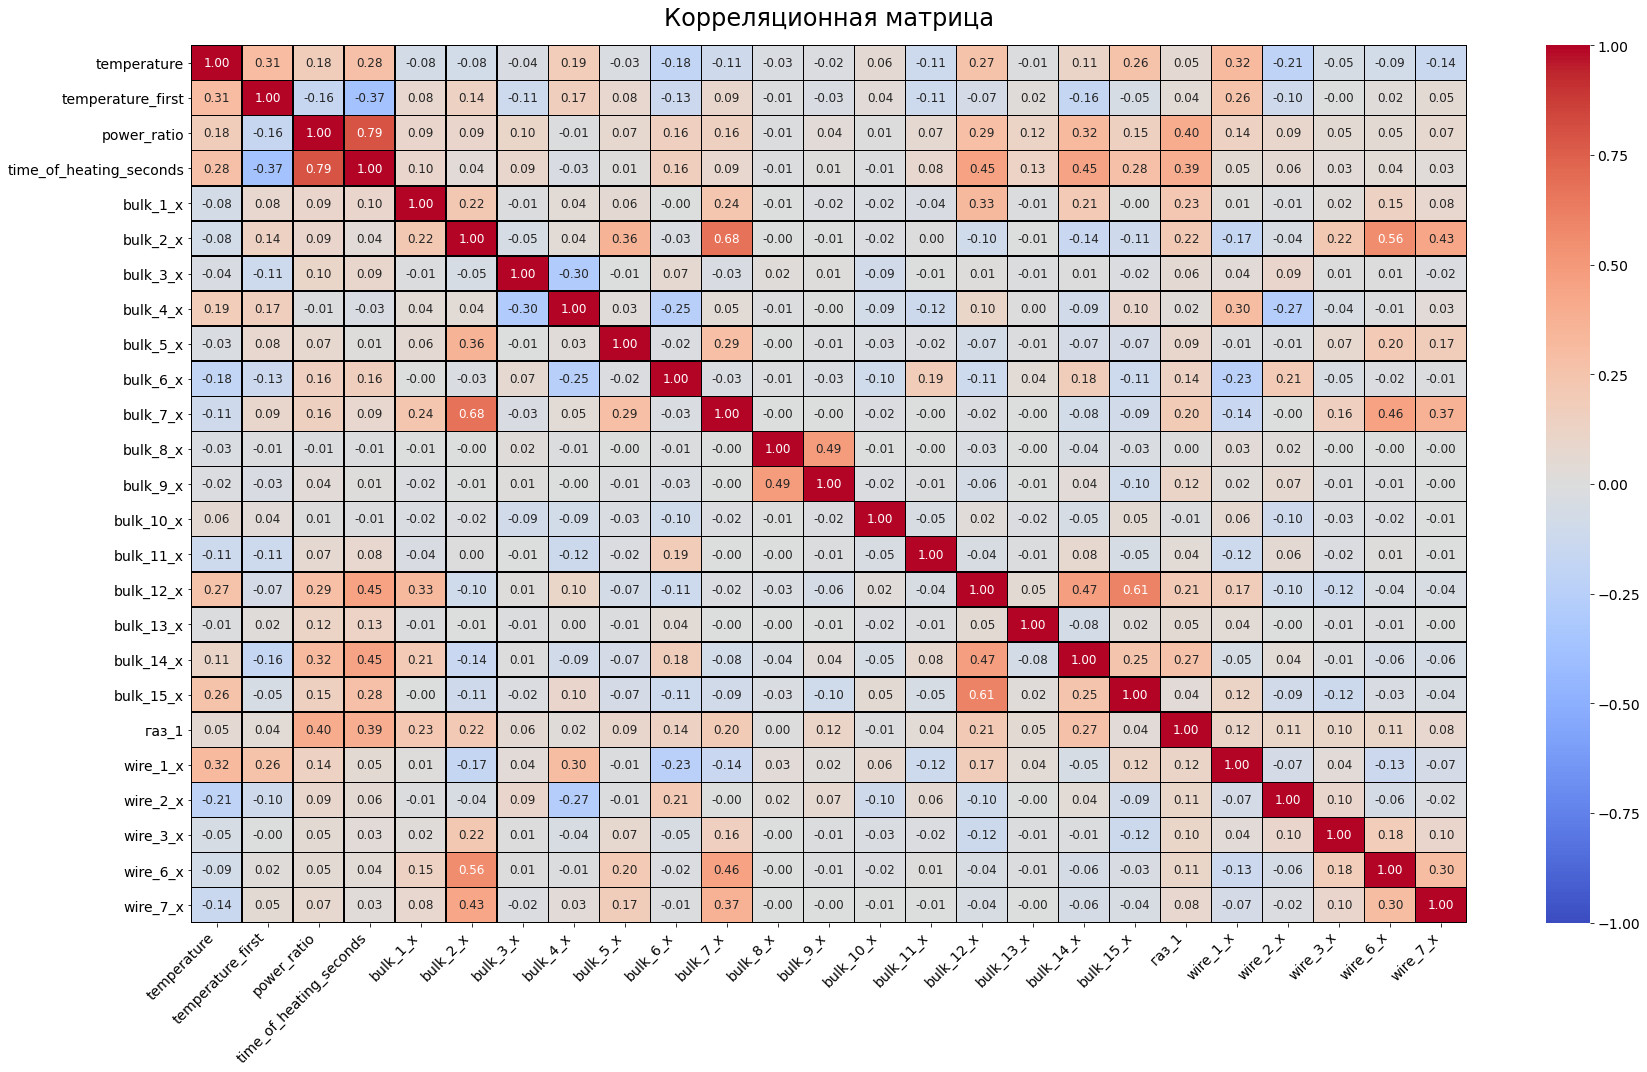

In [35]:
# Настройка размера графика 
plt.figure(figsize=(25, 15))

# Построение тепловой карты
heatmap = sns.heatmap(
    data.corr(),  # Вычисление корреляционной матрицы
    annot=True,   # Добавление числовых значений в ячейки
    cmap='coolwarm',  # Цветовая схема
    fmt=".2f",    # Формат отображения чисел (2 знака после запятой)
    linewidths=0.5,  # Толщина линий между ячейками
    linecolor='black',  # Цвет линий между ячейками
    vmin=-1, vmax=1,  # Диапазон значений для цветовой шкалы
    annot_kws={"size": 12}  # Размер шрифта для аннотаций
)

# Настройка заголовка
plt.title('Корреляционная матрица', fontsize=24, pad=20)

# Настройка подписей осей
heatmap.set_xticklabels(
    heatmap.get_xticklabels(), 
    fontsize=14,  # Увеличиваем размер шрифта для подписей оси X
    rotation=45,  # Поворачиваем подписи на 45 градусов
    ha='right'    # Выравниваем подписи по правому краю
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(), 
    fontsize=14,  # Увеличиваем размер шрифта для подписей оси Y
    rotation=0    # Не поворачиваем подписи оси Y
)

# Увеличиваем размер цветовой шкалы (colorbar)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

# Отображение графика
plt.tight_layout()  
plt.show()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature              2303 non-null   float64
 1   temperature_first        2303 non-null   float64
 2   power_ratio              2303 non-null   float64
 3   time_of_heating_seconds  2303 non-null   float64
 4   bulk_1_x                 2303 non-null   float64
 5   bulk_2_x                 2303 non-null   float64
 6   bulk_3_x                 2303 non-null   float64
 7   bulk_4_x                 2303 non-null   float64
 8   bulk_5_x                 2303 non-null   float64
 9   bulk_6_x                 2303 non-null   float64
 10  bulk_7_x                 2303 non-null   float64
 11  bulk_8_x                 2303 non-null   float64
 12  bulk_9_x                 2303 non-null   float64
 13  bulk_10_x                2303 non-null   float64
 14  bulk_11_x               

In [37]:
data

,temperature,temperature_first,power_ratio,time_of_heating_seconds,bulk_1_x,bulk_2_x,bulk_3_x,bulk_4_x,bulk_5_x,bulk_6_x,...,bulk_12_x,bulk_13_x,bulk_14_x,bulk_15_x,газ_1,wire_1_x,wire_2_x,wire_3_x,wire_6_x,wire_7_x
0,1613.0,1571.0,4.083428,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,...,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0
1,1602.0,1581.0,3.301105,811.0,0.0,0.0,0.0,73.0,0.0,0.0,...,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0
2,1599.0,1596.0,4.048621,655.0,0.0,0.0,0.0,34.0,0.0,0.0,...,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0
3,1625.0,1601.0,3.175691,741.0,0.0,0.0,0.0,81.0,0.0,0.0,...,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0
4,1602.0,1576.0,3.187274,869.0,0.0,0.0,0.0,78.0,0.0,0.0,...,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1591.0,1570.0,3.250906,723.0,0.0,0.0,21.0,0.0,0.0,0.0,...,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0
2299,1591.0,1554.0,4.917636,940.0,0.0,0.0,0.0,63.0,0.0,0.0,...,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0
2300,1589.0,1571.0,2.482839,569.0,0.0,0.0,0.0,85.0,0.0,0.0,...,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0
2301,1594.0,1591.0,4.096223,750.0,0.0,0.0,90.0,0.0,0.0,0.0,...,206.0,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0


# Обучение моделей

In [38]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = data.drop('temperature', axis=1)  
y = data['temperature']  

In [39]:
# Разделяем данные на train и test (если нужно)
x_train, x_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE  
)

In [40]:
# Проверка размеров выборок
print(f"Размер тренировочной выборки: {x_train.shape[0]}")     
print(f"Размер тестовой выборки: {x_test.shape[0]}")        

Размер тренировочной выборки: 1727
Размер тестовой выборки: 576


In [41]:
# Функция для обучения модели и вывода результатов на кросс-валидации (без подбора гиперпараметров)
def train_and_evaluate_cv(model, X_train, y_train):
    start_time = time.time()  # Начало отсчета времени
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    end_time = time.time()  # Конец отсчета времени
    training_time = end_time - start_time  # Общее время обучения
    
    # Оценка модели на кросс-валидации
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    cv_mae_mean = cv_scores.mean()
    cv_mae_std = cv_scores.std()
    
    # Вывод результатов
    print(f"MAE на кросс-валидации: {cv_mae_mean:.4f} ± {cv_mae_std:.4f}")
    print(f"Время обучения: {training_time:.2f} секунд")
    print("-" * 50)
    
    return model

In [42]:
# Функция для обучения модели с подбором гиперпараметров и вывода результатов на кросс-валидации
def train_and_evaluate_with_grid(model, param_grid, X_train, y_train):
    start_time = time.time()  # Начало отсчета времени
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',  # Используем MAE для оптимизации
        cv=5,  # Кросс-валидация на 5 фолдов
        n_jobs=-1  # Использование всех ядер процессора
    )
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()  # Конец отсчета времени
    training_time = end_time - start_time  # Общее время обучения
    
    # Лучшие параметры и модель
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Оценка модели на кросс-валидации
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    cv_mae_mean = cv_scores.mean()
    cv_mae_std = cv_scores.std()
    
    # Вывод результатов
    print(f"Лучшие параметры: {best_params}")
    print(f"Средний MAE на кросс-валидации: {cv_mae_mean:.4f} ± {cv_mae_std:.4f}")
    print(f"Время обучения: {training_time:.2f} секунд")
    print("-" * 50)
    
    return best_model

In [43]:
# Линейная регрессия 
print("Линейная регрессия:")
linear_model = LinearRegression()  
best_linear = train_and_evaluate_cv(linear_model, x_train, y_train)

Линейная регрессия:
MAE на кросс-валидации: 6.2241 ± 0.2493
Время обучения: 0.00 секунд
--------------------------------------------------


In [44]:
# Случайный лес 
print("Случайный лес:")
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20],     # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]  # Минимальное количество samples для разделения
}
best_rf = train_and_evaluate_with_grid(rf_model, rf_param_grid, x_train, y_train)

Случайный лес:
Лучшие параметры: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Средний MAE на кросс-валидации: 6.1865 ± 0.1562
Время обучения: 118.86 секунд
--------------------------------------------------


In [45]:
# CatBoost 
print("CatBoost:")
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
catboost_param_grid = {
    'iterations': [100, 200, 300],  # Количество итераций
    'depth': [4, 6, 8],             # Глубина деревьев
    'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения
    'l2_leaf_reg': [1, 3, 5],       # Коэффициент L2-регуляризации
    'border_count': [32, 64, 128],  # Количество границ для разделения
}
best_catboost = train_and_evaluate_with_grid(catboost_model, catboost_param_grid, x_train, y_train)

CatBoost:
Лучшие параметры: {'border_count': 32, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Средний MAE на кросс-валидации: 5.9963 ± 0.1477
Время обучения: 1453.13 секунд
--------------------------------------------------


In [46]:
# LightGBM (с подбором гиперпараметров)
print("LightGBM:")
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_STATE)
lgb_param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [5, 10, 15],        # Максимальная глубина дерева
    'learning_rate': [0.1, 0.2],     # Скорость обучения
    'num_leaves': [31, 63, 127]      # Количество листьев в дереве
}
best_lgb = train_and_evaluate_with_grid(lgb_model, lgb_param_grid, x_train, y_train)

LightGBM:
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 31}
Средний MAE на кросс-валидации: 6.2020 ± 0.2139
Время обучения: 2311.03 секунд
--------------------------------------------------


# Сравнение моделей машинного обучения

Ниже представлены результаты сравнения различных моделей машинного обучения по метрике **MAE (средняя абсолютная ошибка)** и времени обучения.


1. **Точность (MAE)**:
   - **CatBoost** показывает наилучшую точность с MAE = **5.9963** и наименьшим разбросом ошибки (**0.1477**).
   - **Случайный лес** и **LightGBM** близки по точности, но немного уступают CatBoost.
   - **Линейная регрессия** имеет самую низкую точность, но её разброс ошибки относительно небольшой.

2. **Время обучения**:
   - **Линейная регрессия** обучается мгновенно (**0.00 сек**).
   - **Случайный лес** требует умеренного времени обучения (**118.86 сек**).
   - **CatBoost** и **LightGBM** занимают значительно больше времени (**1453.13 сек** и **2311.03 сек** соответственно).


# Проверка моделей на тестовой выборке

In [50]:
# Предсказания и оценка для CatBoost
y_test_pred_catboost = best_catboost.predict(x_test)
test_mae_catboost = mean_absolute_error(y_test, y_test_pred_catboost)

In [51]:
print(f"\nCatBoost:")
print(f"MAE на тестовой выборке: {test_mae_catboost:.4f}")
print(f"Пример предсказаний: {y_test_pred_catboost[:5]}")


CatBoost:
MAE на тестовой выборке: 6.3836
Пример предсказаний: [1600.49243557 1588.99639233 1599.46011773 1584.44484667 1587.90860697]


# Анализ важности факторовв

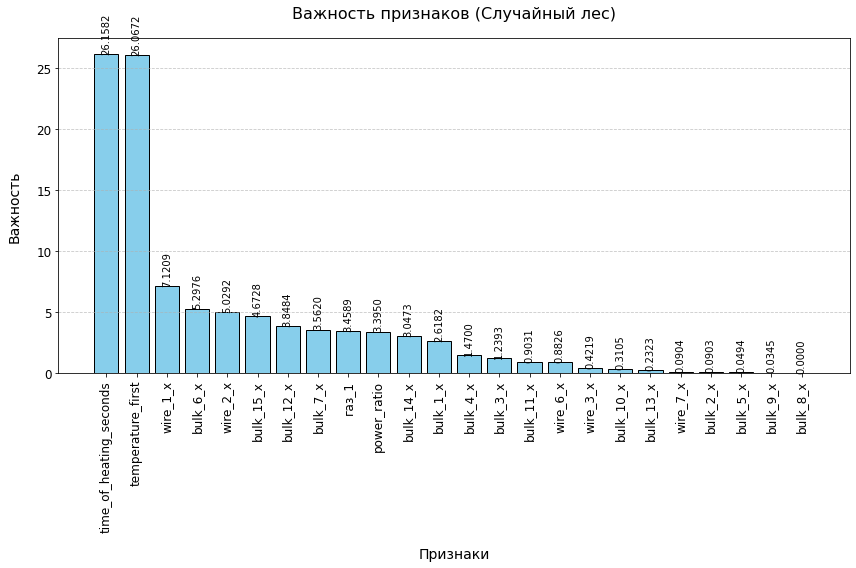

In [52]:
# Важность признаков
importances = best_catboost.feature_importances_
feature_names = x_train.columns  

# Сортировка по важности
indices = np.argsort(importances)[::-1]

# Визуализация
plt.figure(figsize=(12, 8))
plt.title("Важность признаков (Случайный лес)", fontsize=16, pad=20)
bars = plt.bar(range(x_train.shape[1]), importances[indices], align="center", color='skyblue', edgecolor='black')

# Добавление значений важности на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, rotation=90)

plt.xticks(range(x_train.shape[1]), feature_names[indices], rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Признаки", fontsize=14, labelpad=15)
plt.ylabel("Важность", fontsize=14, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()


**Наиболее важные признаки:**
- Признак time_of_heating_seconds имеет наибольшую важность (значение около 0.200).
- За ним следуют temperature_first и wire_1_x.

**Менее важные признаки:**
- Признаки, такие как bulk_8_x, bulk_9_x, bulk_5_x, , bulk_2, , bulk_7_x имеют очень низкую важность (близкую к 0.000).

# Общий вывод

В рамках проекта была поставлена задача разработать модель для прогнозирования температуры сплава на основе данных о технологических операциях, выполняемых с ним.

# Что было сделано:
1. **Предобработка данных:**
   - Данные были загружены и визуально проанализированы.
   - Удалены выбросы и некорректные данные, заполнены пропуски.
   - Разработаны новые признаки, выделена целевая переменная.

2. **Анализ данных:**
   - Данные объединены в единый датафрейм, проведен корреляционный анализ.
   - Устранена мультиколлинеарность для улучшения качества моделей.

3. **Обучение моделей:**
   - Разработан пайплайн для подготовки данных и обучения моделей.
   - Протестированы несколько моделей машинного обучения.
   - Наилучший результат показал **CatBoost** с **MAE = 6.3836** на тестовой выборке.

# Рекомендации для бизнеса:
1. **Расширение данных:**
   - Дополнить датасет информацией о сыпучих материалах и проволоках, которые представлены в недостаточном количестве.
   - Предоставить данные о химическом составе стали, так как сплавы с разным составом могут нагреваться по-разному.
   

2. **Улучшение модели:**
   - Повторить цикл обучения с обновленными данными и оценить результаты.
   - Рассмотреть возможность использования более сложных моделей или ансамблей для повышения точности прогнозирования.
   

3. **Оптимизация процесса:**
   - Провести анализ технологического процесса для выявления факторов, которые могут влиять на температуру сплава.
   - Внедрить систему мониторинга качества данных и моделей для обеспечения стабильности предсказаний.

---

# Заключение:

Проект показал, что использование методов машинного обучения позволяет эффективно прогнозировать температуру сплава. Однако для дальнейшего улучшения результатов необходимо расширить и обогатить данные, а также оптимизировать процесс обучения моделей.